In [1]:
%load_ext autoreload 
%autoreload 2
import cv2
import json, os, cv2
from pathlib import Path
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import xarray as xr
import seaborn as sns
import h5py as hf
from tqdm import tqdm
from tqdm import tqdm
import itertools 
from scipy.interpolate import interp1d
from scipy import signal
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors
import os, fnmatch
from scipy.spatial.distance import cdist

import sys
sys.path.insert(0, 'C:/Users/nlab/Documents/GitHub/obstacle_avoidance')

from utils.base_functions import *
from src.utils.auxiliary import flatten_series
from src.utils.path import find
from src.base import BaseInput
from plots.plots import plot_oa

import warnings
warnings.filterwarnings('ignore')

Loading DLC 2.2.3...


In [2]:
session = plot_oa('D:/obstacle_avoidance/metadata/101222_101322_101422.json')
session.gather_session_df()
session.process_df()

df = session.df

In [ ]:
df['facing_angle']

In [ ]:
for ind, row in df.iterrows():
    spine_x = row['ts_midspine_x_cm']
    spine_y = row['ts_midspine_y_cm']
    tail_x = row['ts_tailbase_x_cm']
    tail_y = row['ts_tailbase_y_cm']
    angs = []
    for step in range(len(spine_x)):
        ang = np.arctan2(spine_y[step]-tail_y[step],spine_x[step]-tail_x[step])
        angs.append(ang)
    df.at[ind, 'body_angle_tailbase'] = np.array(angs).astype(object)

In [ ]:
## plot traces by cluster/animal
savepath,filename = 'D:obstacle_avoidance/figures/tracking_oa','101222_101322_101422_cluster_trace_121322_1'
pdf = PdfPages(os.path.join(savepath,(filename) + '_figs.pdf'))
by_animal = df.groupby(['animal'])
for animal,animal_frame in by_animal:
    by_direction = animal_frame.groupby(['odd'])
    for direction,direction_frame in by_direction:
        fig, ax = plt.subplots(3,3, figsize=(25,21),dpi=50)
        if direction == False:
            fig.suptitle('Right Start'+'_'+str(animal_frame['animal'].unique()), size = 20)
            right_by_cluster = direction_frame.groupby(['cluster_label'])
            for cluster,cluster_frame in right_by_cluster:
                plt.subplot(3,3,cluster+1)
                plt.gca().set_title(str(cluster))
                plt.plot([cluster_frame['mean_arenaTL_x_cm'].unique(), cluster_frame['mean_arenaTR_x_cm'].unique(), cluster_frame['mean_arenaBR_x_cm'].unique(), cluster_frame['mean_arenaBL_x_cm'].unique(),cluster_frame['mean_arenaTL_x_cm'].unique()],
                            [cluster_frame['mean_arenaTL_y_cm'].unique(), cluster_frame['mean_arenaTR_y_cm'].unique(), cluster_frame['mean_arenaBR_y_cm'].unique(), cluster_frame['mean_arenaBL_y_cm'].unique(),cluster_frame['mean_arenaTL_y_cm'].unique()],color='red')
                plt.scatter(cluster_frame['mean_leftportT_x_cm'].unique(),cluster_frame['mean_leftportT_y_cm'].unique(),color='blue')
                plt.scatter(cluster_frame['mean_rightportT_x_cm'].unique(),cluster_frame['mean_rightportT_y_cm'].unique(),color='black')
                for ind,row in cluster_frame.iterrows():
                    plt.subplot(3,3,cluster+1)
                    #plt.plot([row['arenaTL_x_cm'], row['arenaTR_x_cm'], row['arenaBR_x_cm'], row['arenaBL_x_cm'],row['arenaTL_x_cm']],
                            #[row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBR_y_cm'], row['arenaBL_y_cm'],row['arenaTL_y_cm']],color='red')


                    plt.plot([row['gt_obstacleTL_x_cm'], row['gt_obstacleTR_x_cm'], row['gt_obstacleBR_x_cm'], row['gt_obstacleBL_x_cm'],row['gt_obstacleTL_x_cm']],
                            [row['gt_obstacleTL_y_cm'], row['gt_obstacleTR_y_cm'], row['gt_obstacleBR_y_cm'], row['gt_obstacleBL_y_cm'],row['gt_obstacleTL_y_cm']],color='green')




                    plt.scatter(row['gt_obstacle_cen_x_cm'],row['gt_obstacle_cen_y_cm'],color='blue')
                    #plt.scatter(row['leftportT_x_cm'],row['leftportT_y_cm'],color='blue')
                    #plt.scatter(row['rightportT_x_cm'],row['rightportT_y_cm'],color='black')
                    sns.scatterplot(x=row['ts_nose_x_cm'],y=row['ts_nose_y_cm'],hue = enumerate(row['ts_nose_x_cm']), palette ='magma',legend=False) 
                        #plt.scatter(row['wobstacle_x_cm'], row['wobstacle_y_cm'], c = list(mcolors.TABLEAU_COLORS)[ row['obstacle_cluster']])
                    plt.ylim([52,0]); plt.xlim([0, 72])
            pdf.savefig(); plt.close()
               

        if direction ==True:
            fig.suptitle('Left Start'+'_'+str(animal_frame['animal'].unique()), size = 20)
            left_by_cluster = direction_frame.groupby(['cluster_label'])
            for cluster,cluster_frame in left_by_cluster:
                plt.subplot(3,3,cluster+1)
                plt.gca().set_title(str(cluster))
                plt.plot([cluster_frame['mean_arenaTL_x_cm'].unique(), cluster_frame['mean_arenaTR_x_cm'].unique(), cluster_frame['mean_arenaBR_x_cm'].unique(), cluster_frame['mean_arenaBL_x_cm'].unique(),cluster_frame['mean_arenaTL_x_cm'].unique()],
                            [cluster_frame['mean_arenaTL_y_cm'].unique(), cluster_frame['mean_arenaTR_y_cm'].unique(), cluster_frame['mean_arenaBR_y_cm'].unique(), cluster_frame['mean_arenaBL_y_cm'].unique(),cluster_frame['mean_arenaTL_y_cm'].unique()],color='red')
                plt.scatter(cluster_frame['mean_leftportT_x_cm'].unique(),cluster_frame['mean_leftportT_y_cm'].unique(),color='blue')
                plt.scatter(cluster_frame['mean_rightportT_x_cm'].unique(),cluster_frame['mean_rightportT_y_cm'].unique(),color='black')
                for ind,row in cluster_frame.iterrows():
                    plt.subplot(3,3,cluster+1)
                    #plt.plot([row['arenaTL_x_cm'], row['arenaTR_x_cm'], row['arenaBR_x_cm'], row['arenaBL_x_cm'],row['arenaTL_x_cm']],
                            #[row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBR_y_cm'], row['arenaBL_y_cm'],row['arenaTL_y_cm']],color='red')


                    plt.plot([row['gt_obstacleTL_x_cm'], row['gt_obstacleTR_x_cm'], row['gt_obstacleBR_x_cm'], row['gt_obstacleBL_x_cm'],row['gt_obstacleTL_x_cm']],
                            [row['gt_obstacleTL_y_cm'], row['gt_obstacleTR_y_cm'], row['gt_obstacleBR_y_cm'], row['gt_obstacleBL_y_cm'],row['gt_obstacleTL_y_cm']],color='green')




                    plt.scatter(row['gt_obstacle_cen_x_cm'],row['gt_obstacle_cen_y_cm'],color='blue')
                    #plt.scatter(row['leftportT_x_cm'],row['leftportT_y_cm'],color='blue')
                   # plt.scatter(row['rightportT_x_cm'],row['rightportT_y_cm'],color='black')
                    sns.scatterplot(x=row['ts_nose_x_cm'],y=row['ts_nose_y_cm'],hue = enumerate(row['ts_nose_x_cm']), palette ='magma',legend=False) 
                        #plt.scatter(row['wobstacle_x_cm'], row['wobstacle_y_cm'], c = list(mcolors.TABLEAU_COLORS)[ row['obstacle_cluster']])
                    plt.ylim([52,0]); plt.xlim([0, 72])
            pdf.savefig(); plt.close()
            
pdf.close()





In [ ]:
for ind,row in df.iterrows():
    if row['nose_x_cm'][0] <= 20:
        df.at[ind,'odd'] = True 
    elif row['nose_x_cm'][0] >=20:
        df.at[ind,'odd'] = False

In [ ]:
savepath,filename = 'D:obstacle_avoidance/figures/tracking_oa','101222_101322_101422_head_body direction_121322_1'
pdf = PdfPages(os.path.join(savepath,(filename) + '_figs.pdf'))
by_animal = df.groupby(['animal'])
for animal,animal_frame in by_animal:
    by_cluster = animal_frame.groupby(['cluster_label'])
    for cluster,cluster_frame in by_cluster:
        cluster_frame = cluster_frame.reset_index()
        y = nearestX_roundup(len(cluster_frame),4)
        fig, ax = plt.subplots(int((y/4)),4, figsize=(25,len(cluster_frame)),dpi = 100)
        fig.suptitle(str(cluster) + '_' +str(animal) , size = 20)
        for ind,row in cluster_frame.iterrows():
            plt.subplot(int((y/4)),4,ind+1)
            plt.gca().set_aspect('equal', adjustable='box')
            plt.gca().set_title(str(row['odd'])+str(ind))
            for indx,i in enumerate(row['head_angle']):
                    current_ang = i
                    x1 = row['ts_nose_x_cm'][indx]
                    y1 = row['ts_nose_y_cm'][indx]
                    x2 = x1-3 * np.cos(current_ang)
                    y2 = y1-3* np.sin(current_ang)
                    plt.plot((x1,x2), (y1,y2), '-',color = 'black',alpha=0.3)
            for indx,i in enumerate(row['body_angle']):
                    current_ang = i
                    x1 = row['ts_midspine_x_cm'][indx]
                    y1 = row['ts_midspine_y_cm'][indx]
                    x2 = x1-3 * np.cos(current_ang)
                    y2 = y1-3* np.sin(current_ang)
                    plt.plot((x1,x2), (y1,y2), '-',color = 'red',alpha=0.3)
            plt.plot([row['arenaTL_x_cm'], row['arenaTR_x_cm'], row['arenaBR_x_cm'], row['arenaBL_x_cm'],row['arenaTL_x_cm']],
                        [row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBR_y_cm'], row['arenaBL_y_cm'],row['arenaTL_y_cm']],color='orange')


            plt.plot([row['gt_obstacleTL_x_cm'], row['gt_obstacleTR_x_cm'], row['gt_obstacleBR_x_cm'], row['gt_obstacleBL_x_cm'],row['gt_obstacleTL_x_cm']],
                    [row['gt_obstacleTL_y_cm'], row['gt_obstacleTR_y_cm'], row['gt_obstacleBR_y_cm'], row['gt_obstacleBL_y_cm'],row['gt_obstacleTL_y_cm']],color='green')

            sns.scatterplot(x=row['obstacle_intersect_nose_x'],y=row['obstacle_intersect_nose_y'],hue = enumerate(row['obstacle_intersect_nose_x']), palette ='magma',legend=False)    
            plt.scatter(row['gt_obstacleTL_x_cm'],row['gt_obstacleTL_y_cm'],color = 'blue')
            plt.scatter(row['gt_obstacleTR_x_cm'],row['gt_obstacleTR_y_cm'],color = 'red')
            plt.scatter(row['gt_obstacleBL_x_cm'],row['gt_obstacleBL_y_cm'],color = 'orange')
            plt.scatter(row['gt_obstacleBR_x_cm'],row['gt_obstacleBR_y_cm'],color = 'green')
            plt.scatter(row['gt_obstacle_cen_x_cm'],row['gt_obstacle_cen_y_cm'],color='blue')
            plt.scatter(row['leftportT_x_cm'],row['leftportT_y_cm'],color='blue')
            plt.scatter(row['rightportT_x_cm'],row['rightportT_y_cm'],color='black')
            plt.scatter(row['ts_nose_x_cm'],row['ts_nose_y_cm'], color = 'c',s=1)
            plt.scatter(row['ts_spine_x_cm'],row['ts_spine_y_cm'], color = 'm',s=1)

            plt.ylim([52,0]); plt.xlim([0, 72])
        pdf.savefig(); plt.close()
pdf.close()


    
    

In [ ]:
test = df.sample(30)
test = test.reset_index()

In [ ]:
def facing_angle(df):
    for ind,row in df.iterrows():
        if np.mean(row['head_angle'][:10]) > 0:
            df.at[ind,'facing_angle'] = True ## True means facing dowm postive value
        elif np.mean(row['head_angle'][:10]) == 0:
            df.at[ind,'facing_angle'] = np.nan
        else: 
            df.at[ind,'facing_angle'] = False



In [123]:
df.columns.to_numpy()

array(['first_poke', 'second_poke', 'trial_timestamps', 'trial_vidframes',
       'nose_x', 'nose_y', 'nose_likelihood', 'leftear_x', 'leftear_y',
       'leftear_likelihood', 'rightear_x', 'rightear_y',
       'rightear_likelihood', 'spine_x', 'spine_y', 'spine_likelihood',
       'midspine_x', 'midspine_y', 'midspine_likelihood', 'tailbase_x',
       'tailbase_y', 'tailbase_likelihood', 'midtail_x', 'midtail_y',
       'midtail_likelihood', 'tailend_x', 'tailend_y',
       'tailend_likelihood', 'arenaTL_x', 'arenaTL_y',
       'arenaTL_likelihood', 'arenaTR_x', 'arenaTR_y',
       'arenaTR_likelihood', 'arenaBL_x', 'arenaBL_y',
       'arenaBL_likelihood', 'arenaBR_x', 'arenaBR_y',
       'arenaBR_likelihood', 'obstacleTL_x', 'obstacleTL_y',
       'obstacleTL_likelihood', 'obstacleTR_x', 'obstacleTR_y',
       'obstacleTR_likelihood', 'obstacleBR_x', 'obstacleBR_y',
       'obstacleBR_likelihood', 'obstacleBL_x', 'obstacleBL_y',
       'obstacleBL_likelihood', 'leftportT_x', 'leftpo

In [ ]:
def right_left(df):
    for ind, row in df.iterrows():
        nose_x = row['ts_nose_x_cm']
        cen_x = row['gt_obstacle_cen_x_cm']
        

         

In [ ]:
plt.plot([df.at[0,'mean_arenaTL_x_cm'], df.at[0,'mean_arenaTR_x_cm'], df.at[0,'mean_arenaBR_x_cm'], df.at[0,'mean_arenaBL_x_cm'],df.at[0,'mean_arenaTL_x_cm']],
            [df.at[0,'mean_arenaTL_y_cm'], df.at[0,'mean_arenaTR_y_cm'], df.at[0,'mean_arenaBR_y_cm'], df.at[0,'mean_arenaBL_y_cm'],df.at[0,'mean_arenaTL_y_cm']],color='green')

True


(0.0, 72.0)

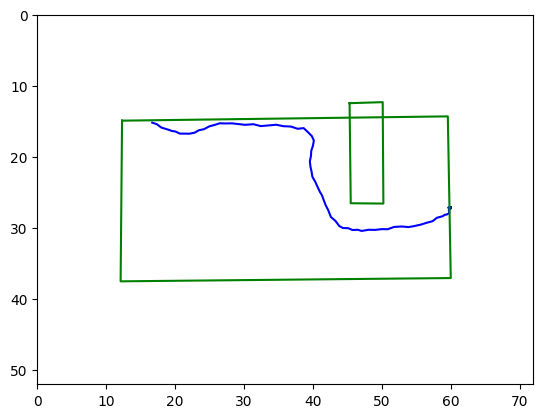

In [147]:
print(df.at[0,'odd'])
plt.plot(df.at[0,'ts_nose_x_cm'],df.at[0,'ts_nose_y_cm'],c ='b')

#plt.plot(df.at[1158,'interp_ts_nose_x_cm'],df.at[1158,'interp_ts_nose_y_cm'],c = 'r')

plt.plot([df.at[0,'mean_arenaTL_x_cm'], df.at[0,'mean_arenaTR_x_cm'], df.at[0,'mean_arenaBR_x_cm'], df.at[0,'mean_arenaBL_x_cm'],df.at[0,'mean_arenaTL_x_cm']],
            [df.at[0,'mean_arenaTL_y_cm'], df.at[0,'mean_arenaTR_y_cm'], df.at[0,'mean_arenaBR_y_cm'], df.at[0,'mean_arenaBL_y_cm'],df.at[0,'mean_arenaTL_y_cm']],color='green')

plt.plot([df.at[0,'gt_obstacleTL_x_cm'], df.at[0,'gt_obstacleTR_x_cm'], df.at[0,'gt_obstacleBR_x_cm'], df.at[0,'gt_obstacleBL_x_cm'],df.at[0,'gt_obstacleTL_x_cm']],
            [df.at[0,'gt_obstacleTL_y_cm'], df.at[0,'gt_obstacleTR_y_cm'], df.at[0,'gt_obstacleBR_y_cm'], df.at[0,'gt_obstacleBL_y_cm'],df.at[0,'gt_obstacleTL_y_cm']],color='green')

plt.ylim([52,0]); plt.xlim([0, 72])

True


(0.0, 72.0)

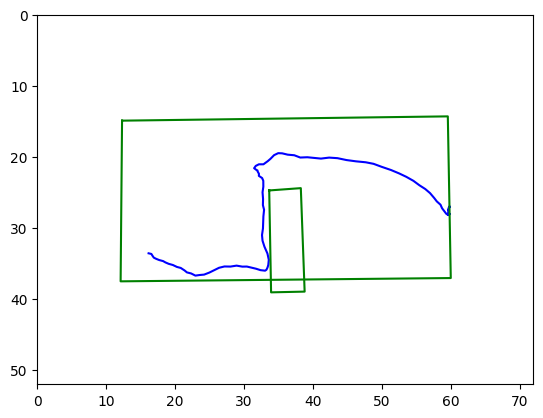

In [146]:
print(df.at[5,'odd'])
plt.plot(df.at[5,'ts_nose_x_cm'],df.at[5,'ts_nose_y_cm'],c ='b')

#plt.plot(df.at[1158,'interp_ts_nose_x_cm'],df.at[1158,'interp_ts_nose_y_cm'],c = 'r')

plt.plot([df.at[5,'mean_arenaTL_x_cm'], df.at[5,'mean_arenaTR_x_cm'], df.at[5,'mean_arenaBR_x_cm'], df.at[5,'mean_arenaBL_x_cm'],df.at[5,'mean_arenaTL_x_cm']],
            [df.at[5,'mean_arenaTL_y_cm'], df.at[5,'mean_arenaTR_y_cm'], df.at[5,'mean_arenaBR_y_cm'], df.at[5,'mean_arenaBL_y_cm'],df.at[5,'mean_arenaTL_y_cm']],color='green')

plt.plot([df.at[5,'gt_obstacleTL_x_cm'], df.at[5,'gt_obstacleTR_x_cm'], df.at[5,'gt_obstacleBR_x_cm'], df.at[5,'gt_obstacleBL_x_cm'],df.at[5,'gt_obstacleTL_x_cm']],
            [df.at[5,'gt_obstacleTL_y_cm'], df.at[5,'gt_obstacleTR_y_cm'], df.at[5,'gt_obstacleBR_y_cm'], df.at[5,'gt_obstacleBL_y_cm'],df.at[5,'gt_obstacleTL_y_cm']],color='green')

plt.ylim([52,0]); plt.xlim([0, 72])

In [137]:
df.at[0,'ts_nose_y_cm']

array([15.18976327522734, 15.411035835735008, 15.879690522649705,
       16.04929050519363, 16.236077281791502, 16.364712974264474,
       16.42915343448447, 16.739166463106553, 16.73296363805864,
       16.748691886687883, 16.6011576127834, 16.25851964776589,
       16.10870619628566, 15.713910005761898, 15.52065433978589,
       15.28027964260612, 15.304135675684453, 15.291537689928225,
       15.392368057095977, 15.496145968259366, 15.409575687513136,
       15.677806999507569, 15.584671661553003, 15.486376919508196,
       15.689517035631614, 15.738958519934714, 16.056168107850116,
       15.95950982171588, 16.590346745871724, 17.093966453050047,
       17.71551196201138, 18.44825953862756, 19.147837227810516,
       19.90641067522696, 20.633351317696217, 21.345871594026953,
       22.071246303661113, 22.81726023245341, 23.541525806445932,
       24.132869808332888, 24.937414684179377, 25.43246102929535,
       26.06566368207412, 26.853819956857322, 27.489545412381673,
       28.46

In [148]:
test = np.argwhere(df.at[5,'ts_nose_x_cm']>=df.at[5,'gt_obstacle_cen_x_cm'])

In [151]:
print(df.at[5,'ts_nose_x_cm'],df.at[5,'gt_obstacle_cen_x_cm'])

[16.147162108785555 16.553195510268214 16.74187519032386
 16.908785679216518 17.23974406125621 17.678984214507 18.25949811591624
 18.58305958901637 19.067979461612257 19.668616481490897
 20.260874077764754 20.816972569883333 21.37563714027109
 21.710067180981007 22.326349104036048 22.944169712374293
 23.552493747480266 24.2112818514838 24.97503233375936 25.802409055292546
 26.37811777078612 27.160231500238407 28.028223102059485
 28.920301539751375 29.757301455493266 30.412656367958654
 31.120082954883117 31.731216693428106 32.40153852586699
 33.060349069030906 33.25220389028033 33.34762802259366 33.40744120738385
 33.5230189113128 33.59753615734061 33.40291170258142 32.966780975840436
 32.68808980951456 32.61166844044879 32.7499738082484 32.783042719459914
 32.81340290345412 32.91156140773948 32.74139563779454 32.76465222473129
 32.69083059267527 32.80449455678324 32.798692431027824 32.627686795365804
 32.154675705743045 32.16753655023515 31.984708682647188
 31.954258742011458 31.80351

In [150]:
test.flatten()

array([ 63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140],
      dtype=int64)

In [149]:
np.mean(df.at[5,'ts_nose_y_cm'][test.flatten()])

25.984485621981413

In [142]:
df.at[5,'ts_nose_y_cm']

array([33.5727120347716, 33.66451705107506, 33.96133905898802,
       34.18626599704329, 34.34682139515689, 34.519275959460586,
       34.67119869201654, 34.85168968133064, 35.05501732472295,
       35.21707294098767, 35.490048532605314, 35.63377776602821,
       35.988707582542474, 36.256358681961366, 36.40967905364956,
       36.71239614955379, 36.62732608695868, 36.5696927063197,
       36.28118921571906, 35.87826203515187, 35.610107657421594,
       35.42488200526731, 35.44043875459936, 35.30712129159281,
       35.448157825770096, 35.43593810014599, 35.604039467335966,
       35.73982203238998, 35.94333560025401, 36.01775667845162,
       35.88939185870037, 35.71667123006645, 35.587283825720746,
       35.21079638726994, 34.487014858022754, 33.608823055011776,
       32.64321148875446, 31.8012300794082, 31.00947712777551,
       30.07630297064473, 29.222415983919685, 28.37873881516756,
       27.4469366524143, 26.788837751193867, 25.933761488968678,
       24.989237925077102, 24.2

In [125]:
df.at[0,'gt_obstacle_cen_x_cm']

47.79505979552678

In [126]:
df.at[0,'ts_nose_x_cm']

array([16.67372425465531, 17.34926158908538, 17.99520167097417,
       18.576662825510883, 19.197187352674923, 19.51142695743431,
       20.018180133079987, 20.72103393967843, 21.36014931121734,
       22.043691014714412, 22.83406075238939, 23.448130815349828,
       24.198440240557733, 24.952761467082162, 25.69600896795903,
       26.479711069406793, 27.32435793044677, 28.258900876360734,
       29.259004637716526, 30.156817883682688, 31.356011492713296,
       32.43022218402137, 33.55131789814639, 34.68287987779153,
       35.71544348743423, 36.80481984556488, 37.790953626786916,
       38.654704227296165, 39.345352733445026, 39.85527944748731,
       40.136044633351176, 40.004243416467446, 39.76177226058931,
       39.71277154550796, 39.554876790696575, 39.638671026744355,
       39.801592153480875, 39.93299267107211, 40.35879497284959,
       40.627532768749745, 41.020971390070514, 41.32676906213549,
       41.562014808371245, 41.874143529257736, 42.22040221308228,
       42.608535

In [6]:
right = df[df['odd']==False]

In [7]:
right

,first_poke,second_poke,trial_timestamps,trial_vidframes,nose_x,nose_y,nose_likelihood,leftear_x,leftear_y,leftear_likelihood,...,obstacle_intersect_body_y,all_obstacle_intersect_nose_x,all_obstacle_intersect_nose_y,obstacle_intersect_nose_x,obstacle_intersect_nose_y,normalized_counts_intersect_nose_y,sum_normalized_counts_intersect_nose_y,bins_intersect_nose_y,mean_normalized_counts_intersect_nose_y,facing_angle
1,54994.300480,55007.392537,"[54994.317478, 54994.333721, 54994.350387, 549...","[[749, 750, 751, 752, 753, 754, 755, 756, 757,...","[569.2864990234375, 569.2193603515625, 568.796...","[258.95068359375, 258.351318359375, 258.500427...","[0.9951784610748291, 0.9959314465522766, 0.997...","[564.2037963867188, nan, nan, 563.220397949218...","[261.7225036621094, nan, nan, 259.137145996093...","[0.996788501739502, 0.9819933176040649, 0.9842...",...,"[16.64763998399845, 18.2988587186315, 20.21781...","[50.18850533196205, 50.19210559938958, 50.1959...","[18.819020972265747, 19.622235503782363, 20.47...","[50.18850533196205, 50.19210559938958, 50.1959...","[18.819020972265747, 19.622235503782363, 20.47...","[0, 0, 0, 0, 0.025, 0.175, 0.07499999999999998...",1.0,"[-15.0, -12.0, -9.0, -6.0, -3.0, 0.0, 3.0, 6.0...","[0.0, 0.025132625994694957, 0.0217380320828596...",False
4,55026.874713,55030.753984,"[55026.87822, 55026.896179, 55026.911628, 5502...","[[2702, 2703, 2704, 2705, 2706, 2707, 2708, 27...","[569.4076538085938, 569.504150390625, 569.1824...","[258.5302734375, 258.6011962890625, 258.704528...","[0.9999992847442627, 0.9999994039535522, 0.999...","[559.6817016601562, 559.5265502929688, 559.330...","[246.50709533691406, 246.5774688720703, 246.78...","[0.9999991655349731, 0.9999991655349731, 0.999...",...,"[38.03089778008775, 36.849197231672576, 37.655...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.731373592875...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 42.408190347605...","[38.73137359287577, 38.65622474917655, 38.6282...","[42.408190347605014, 38.5716970831311, 37.1417...","[0, 0, 0.3333333333333333, 0.1111111111111111,...",1.0,"[-15.0, -12.0, -9.0, -6.0, -3.0, 0.0, 3.0, 6.0...","[0.030303030303030307, 0.18073769302217577, 0....",True
6,55035.444403,55039.126873,"[55035.447872, 55035.464524, 55035.481664, 550...","[[3216, 3217, 3218, 3219, 3220, 3221, 3222, 32...","[569.5528564453125, 569.843994140625, 569.4065...","[257.44287109375, 257.307861328125, 257.387817...","[0.999998927116394, 0.9999992847442627, 0.9999...","[554.6173095703125, 554.6605224609375, 554.862...","[250.03273010253906, 249.80686950683594, 249.8...","[0.9999991655349731, 0.9999991655349731, 0.999...",...,"[38.32179437155793, 37.336719956321296, 35.184...","[0.0, 0.0, 0.0, 0.0, 38.760453478348936, 38.70...","[0.0, 0.0, 0.0, 0.0, 43.29006496826983, 39.793...","[38.760453478348936, 38.70161560137967, 38.646...","[43.29006496826983, 39.793222572933324, 36.488...","[0, 0.045454545454545456, 0.40909090909090917,...",1.0,"[-15.0, -12.0, -9.0, -6.0, -3.0, 0.0, 3.0, 6.0...","[0.030303030303030307, 0.18073769302217577, 0....",True
8,55042.281177,55047.807078,"[55042.283673, 55042.300467, 55042.317772, 550...","[[3626, 3627, 3628, 3629, 3630, 3631, 3632, 36...","[566.4303588867188, 567.2401733398438, 567.769...","[260.4405822753906, 260.06689453125, 259.48678...","[0.9999991655349731, 0.9999983310699463, 0.999...","[559.9876098632812, 560.5786743164062, 560.548...","[247.10633850097656, 247.01780700683594, 246.5...","[0.9999991655349731, 0.9999984502792358, 0.999...",...,"[32.014735534055475, 30.330428412181476, 29.12...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.249736216393...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.777044003864...","[39.24973621639329, 39.254969091590475, 39.260...","[37.77704400386495, 35.10428474338168, 32.0973...","[0, 0, 0.20833333333333331, 0.2500000000000000...",1.0,"[-15.0, -12.0, -9.0, -6.0, -3.0, 0.0, 3.0, 6.0...","[0.01433541030850735, 0.06023259411680532, 0.4...",True
10,55050.609011,55053.791795,"[55050.619955, 55050.63648, 55050.653286, 5505...","[[4126, 

In [11]:
test = right.sample(30)
test = test.reset_index()

In [16]:
test['head_angle'][7]

array([2.5287183920464273, 2.7396949431603463, 2.8561312771138967,
       3.1190290108391006, -3.1074894561110646, -3.0278724881941503,
       -3.0051868096211076, -2.9591367041544903, -2.920192880007862,
       -2.8335094164767964, -2.804839857889668, -2.8129082711919984,
       -2.8425531677142843, -2.9716362851576936, -3.0825659793670734,
       -3.1263598078685626, 2.9586732221607805, 2.9568407682580684,
       2.982926634333146, 3.009126928422131, 3.0345365172008827,
       2.9819575653484782, 2.9612688055782845, 2.951380646656947,
       2.968403622390697, 2.9798647070992716, 2.957535017428805,
       2.952203775855415, 2.9094961098536882, 2.9149053298612206,
       2.946920601944802, 2.9545275920577363, 2.899063863488445,
       2.929408038360551, 2.8767595494919584, 2.8841032384895304,
       2.981519662324317, 3.0495160548213347, -3.1346994347615036,
       -3.10367939637329, -3.140427306151089, -3.0657355632431873,
       3.0847870383126565, 3.0407815603805344, 2.977370331050

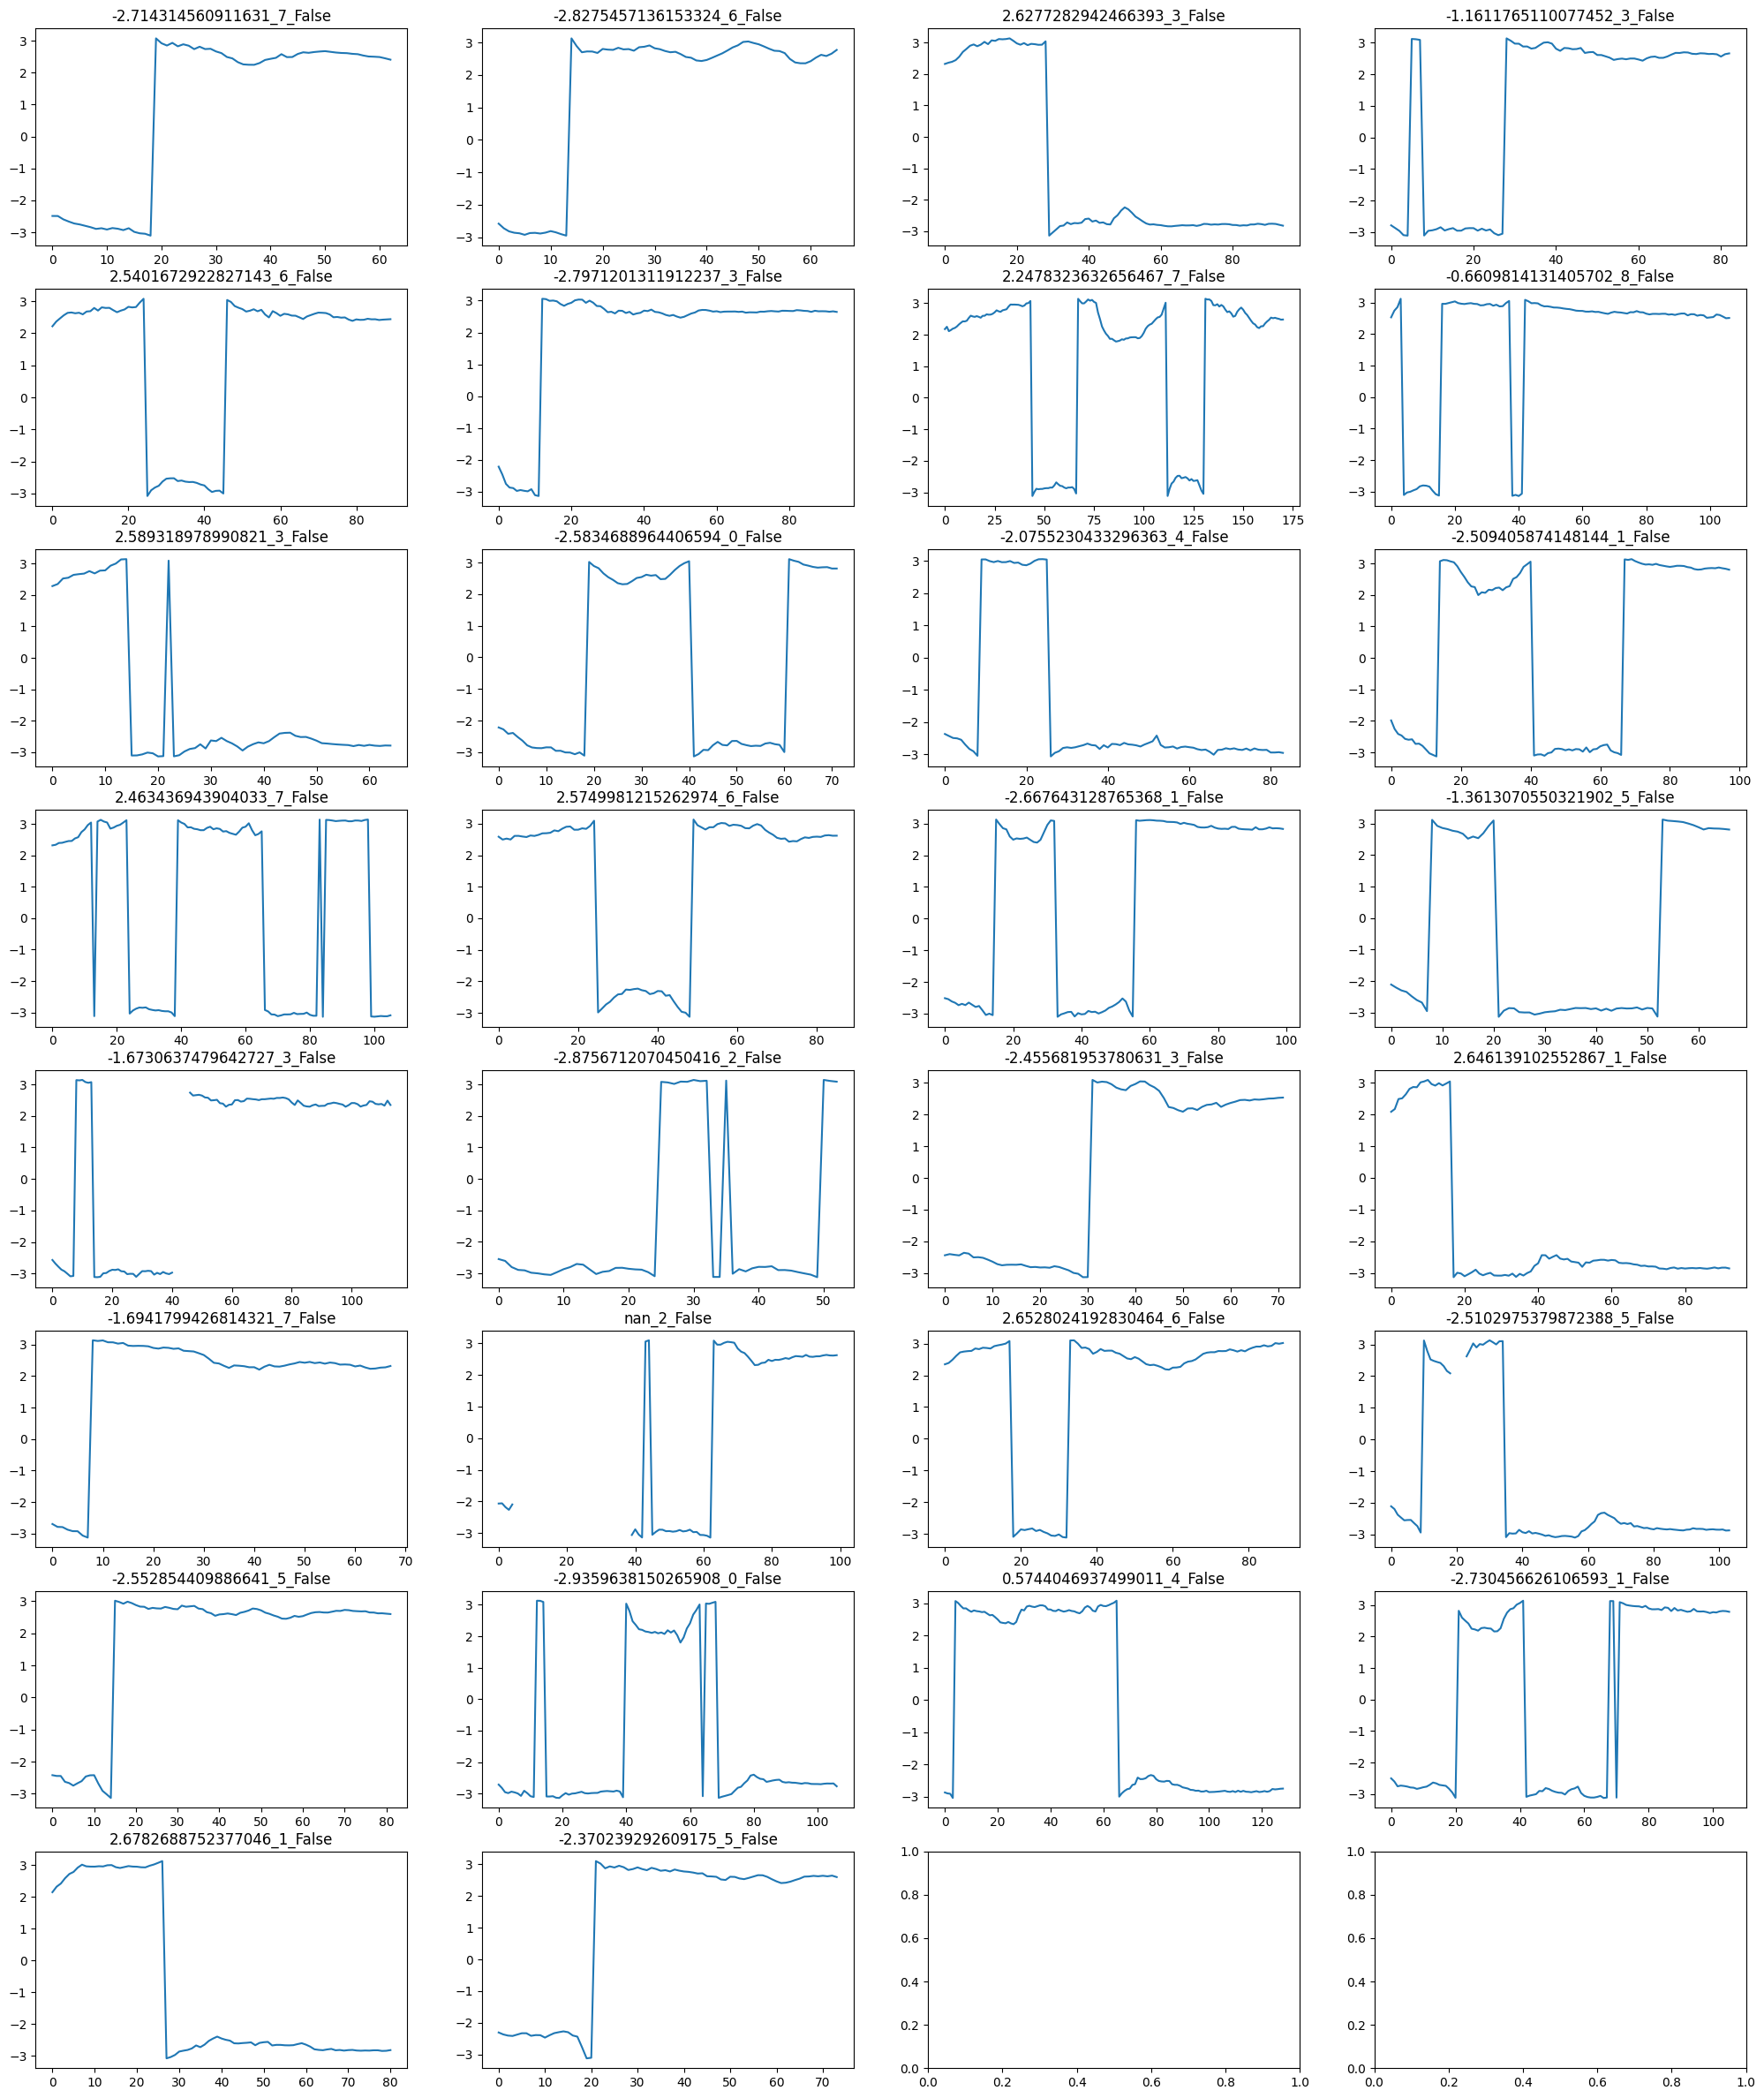

In [12]:
y = nearestX_roundup(len(test),4)
fig, ax = plt.subplots(int((y/4)),4, figsize=(25,len(test)),dpi = 100)
for ind,row in test.iterrows():
    plt.subplot(int((y/4)),4,ind+1)
    plt.plot(row['head_angle'])
    plt.gca().set_title(str(np.mean(row['head_angle'][:10]))+'_' + str(row['cluster_label']) + '_' + str(row['odd']))
    if np.mean(row['head_angle'][:10]) > 0:
        test.at[ind,'facing_angle'] = True ## True means facing dowm postive value
    elif np.mean(row['head_angle'][:10]) == 0:
        test.at[ind,'facing_angle'] = np.nan
    else: 
        test.at[ind,'facing_angle'] = False

    


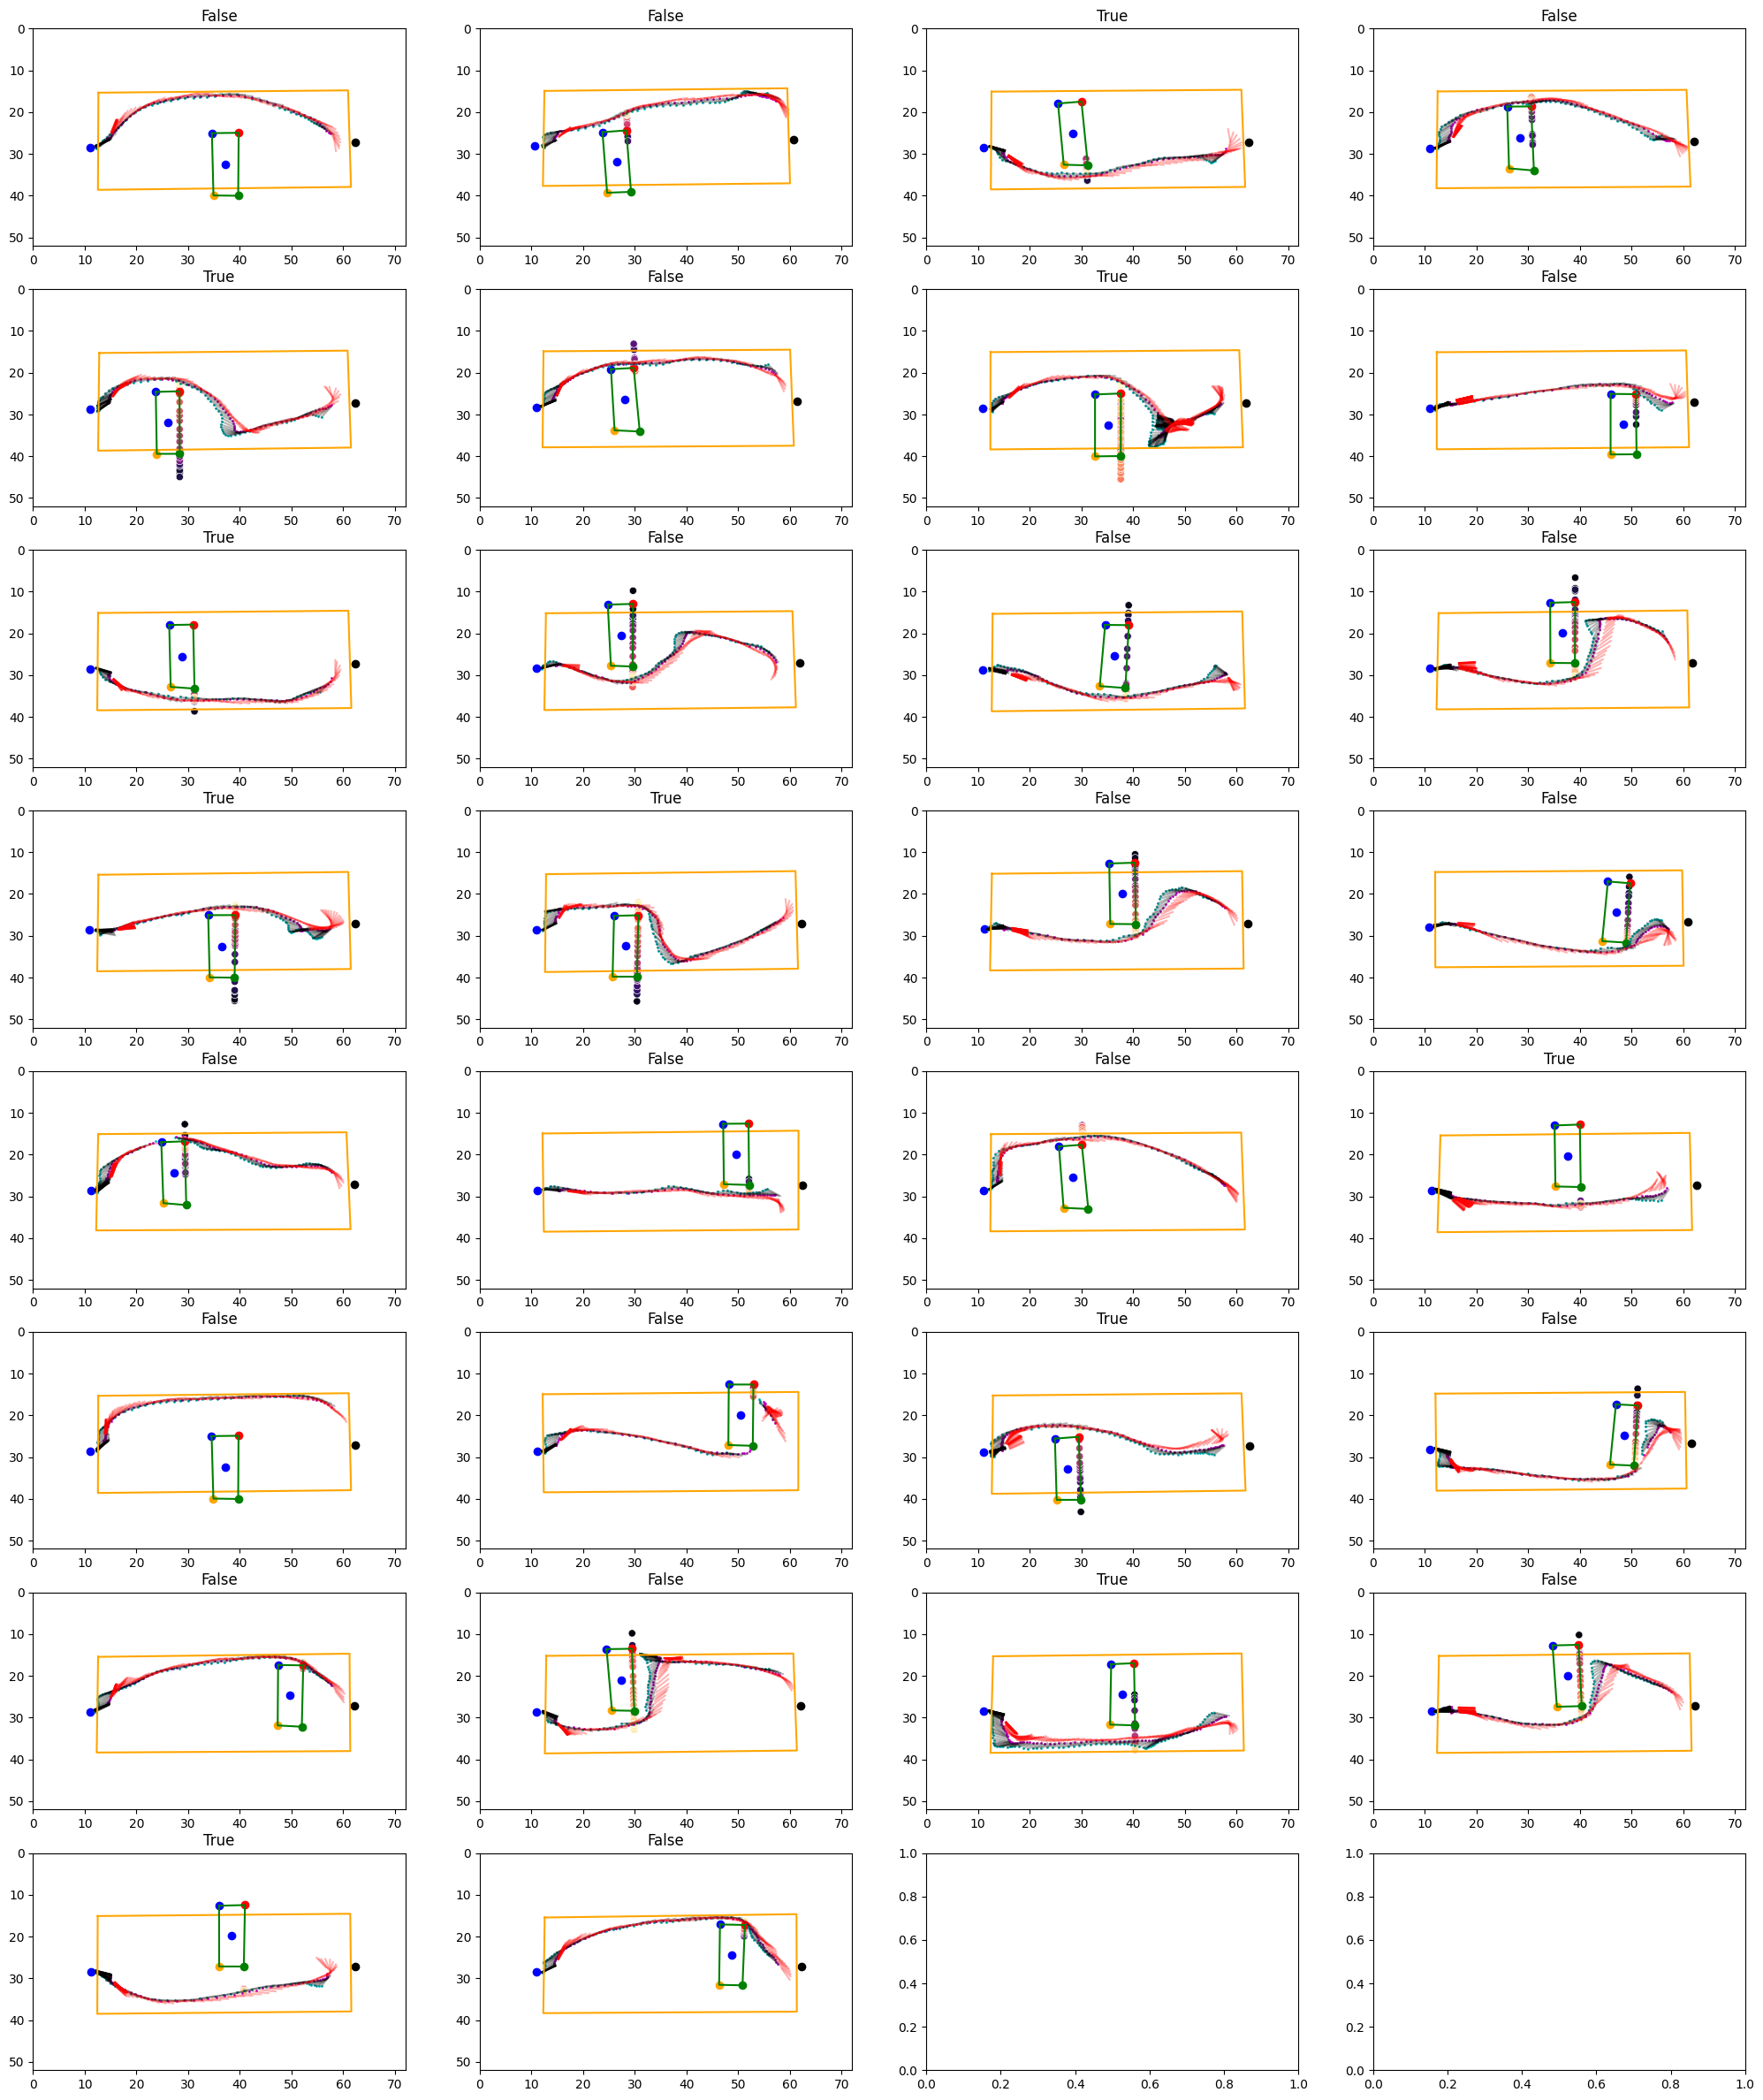

In [13]:
y = nearestX_roundup(len(test),4)
fig, ax = plt.subplots(int((y/4)),4, figsize=(25,len(test)),dpi = 100)
for ind,row in test.iterrows():
    plt.subplot(int((y/4)),4,ind+1)
    plt.gca().set_title(str(row['facing_angle']))
    for indx,i in enumerate(row['head_angle']):
                    current_ang = i
                    x1 = row['ts_nose_x_cm'][indx]
                    y1 = row['ts_nose_y_cm'][indx]
                    x2 = x1-3 * np.cos(current_ang)
                    y2 = y1-3* np.sin(current_ang)
                    plt.plot((x1,x2), (y1,y2), '-',color = 'black',alpha=0.3)
    for indx,i in enumerate(row['body_angle']):
            current_ang = i
            x1 = row['ts_midspine_x_cm'][indx]
            y1 = row['ts_midspine_y_cm'][indx]
            x2 = x1-3 * np.cos(current_ang)
            y2 = y1-3* np.sin(current_ang)
            plt.plot((x1,x2), (y1,y2), '-',color = 'red',alpha=0.3)
    plt.plot([row['arenaTL_x_cm'], row['arenaTR_x_cm'], row['arenaBR_x_cm'], row['arenaBL_x_cm'],row['arenaTL_x_cm']],
                [row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBR_y_cm'], row['arenaBL_y_cm'],row['arenaTL_y_cm']],color='orange')
    plt.plot([row['gt_obstacleTL_x_cm'], row['gt_obstacleTR_x_cm'], row['gt_obstacleBR_x_cm'], row['gt_obstacleBL_x_cm'],row['gt_obstacleTL_x_cm']],
            [row['gt_obstacleTL_y_cm'], row['gt_obstacleTR_y_cm'], row['gt_obstacleBR_y_cm'], row['gt_obstacleBL_y_cm'],row['gt_obstacleTL_y_cm']],color='green')
    sns.scatterplot(x=row['obstacle_intersect_nose_x'],y=row['obstacle_intersect_nose_y'],hue = enumerate(row['obstacle_intersect_nose_x']), palette ='magma',legend=False)    
    plt.scatter(row['gt_obstacleTL_x_cm'],row['gt_obstacleTL_y_cm'],color = 'blue')
    plt.scatter(row['gt_obstacleTR_x_cm'],row['gt_obstacleTR_y_cm'],color = 'red')
    plt.scatter(row['gt_obstacleBL_x_cm'],row['gt_obstacleBL_y_cm'],color = 'orange')
    plt.scatter(row['gt_obstacleBR_x_cm'],row['gt_obstacleBR_y_cm'],color = 'green')
    plt.scatter(row['gt_obstacle_cen_x_cm'],row['gt_obstacle_cen_y_cm'],color='blue')
    plt.scatter(row['leftportT_x_cm'],row['leftportT_y_cm'],color='blue')
    plt.scatter(row['rightportT_x_cm'],row['rightportT_y_cm'],color='black')
    plt.scatter(row['ts_nose_x_cm'],row['ts_nose_y_cm'], color = 'c',s=1)
    plt.scatter(row['ts_spine_x_cm'],row['ts_spine_y_cm'], color = 'm',s=1)
    plt.ylim([52,0]); plt.xlim([0, 72])
    


In [17]:
df['animal'].unique()

array(['J19LT', 'J19RT', 'J20LT', 'J20RT'], dtype=object)

In [84]:
J20RT = df[df['animal']=='J20RT']

In [21]:
J20RT['facing_angle']

245     False
246      True
247     False
248      True
249     False
        ...  
1226     True
1227    False
1228     True
1229    False
1230    False
Name: facing_angle, Length: 239, dtype: object

In [66]:
J20RT

,first_poke,second_poke,trial_timestamps,trial_vidframes,nose_x,nose_y,nose_likelihood,leftear_x,leftear_y,leftear_likelihood,...,all_obstacle_intersect_nose_y,obstacle_intersect_nose_x,obstacle_intersect_nose_y,normalized_counts_intersect_nose_y,sum_normalized_counts_intersect_nose_y,bins_intersect_nose_y,mean_normalized_counts_intersect_nose_y,facing_angle,interp_ts_nose_x_cm,interp_ts_nose_y_cm
245,56396.382105,56401.703283,"[56396.387507, 56396.404108, 56396.420454, 563...","[264, 265, 266, 267, 268, 269, 270, 271, 272, ...","[112.0492172241211, 111.85668182373047, 111.71...","[263.0643615722656, 262.69403076171875, 262.92...","[0.9999997615814209, 0.9999996423721313, 0.999...","[123.26714324951172, 122.17658996582031, 122.3...","[273.4779052734375, 273.4393615722656, 273.583...","[0.9999998807907104, 0.9999997615814209, 0.999...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[34.65730438269459, 34.604389561204584, 34.593...","[14.09143771475114, 17.580916801380493, 18.300...","[0, 0.047619047619047616, 0.9523809523809528, ...",1.0,"[-15.0, -12.0, -9.0, -6.0, -3.0, 0.0, 3.0, 6.0...","[0.0412907772511108, 0.1518709321352525, 0.276...",False,"[9.910433267647432, 13.35700569754294, 16.8412...","[13.96354652692109, 18.455928574413733, 22.831..."
246,56401.703283,56405.103193,"[56401.705612, 56401.722419, 56401.73966, 5640...","[[583, 584, 585, 586, 587, 588, 589, 590, 591,...","[567.846923828125, 567.9541015625, 567.9830932...","[261.62213134765625, 261.7710266113281, 261.85...","[0.9999982118606567, 0.9999979734420776, 0.999...","[559.8572998046875, 560.25341796875, 560.58520...","[249.90591430664062, 250.23562622070312, 250.2...","[0.9999986886978149, 0.9999984502792358, 0.999...",...,"[0.0, 0.0, 0.0, 36.575057946054, 35.0613403014...","[39.17196476610385, 39.187250967966506, 39.193...","[36.575057946054, 35.061340301420366, 34.46040...","[0, 0, 0, 0, 0, 0, 0, 0.18181818181818182, 0.8...",1.0,"[-15.0, -12.0, -9.0, -6.0, -3.0, 0.0, 3.0, 6.0...","[0.0023809523809523807, 0.02353328781900211, 0...",True,"[33.51360294155784, 44.641147076577255, 55.718...","[16.883287458354275, 22.488754847926273, 28.08..."
247,56405.103193,56415.839680,"[56405.106944, 56405.123494, 56405.141068, 564...","[787, 788, 789, 790, 791, 792, 793, 794, 795, ...","[112.341796875, 112.5261459350586, 112.2376403...","[262.132080078125, 261.9194030761719, 262.1935...","[0.9999998807907104, 0.9999998807907104, 0.999...","[124.35699462890625, 124.48033905029297, 124.6...","[271.0626525878906, 270.6658020019531, 271.431...","[0.9999998807907104, 0.9999998807907104, 0.999...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[25.566215492398214, 25.57275307954447, 25.586...","[14.22569768356614, 15.37019164071948, 17.7050...","[0.02197802197802198, 0.06593406593406594, 0.3...",1.0,"[-15.0, -12.0, -9.0, -6.0, -3.0, 0.0, 3.0, 6.0...","[0.030321349536689718, 0.08265405522305395, 0....",False,"[10.45526691482189, 14.107718744309224, 17.780...","[14.277329859224785, 19.07794111246258, 23.989..."
248,56415.839680,56420.066956,"[56415.843865, 56415.861337, 56415.877235, 564...","[[1431, 1432, 1433, 1434, 1435, 1436, 1437, 14...","[569.6924438476562, 570.3181762695312, 570.292...","[260.84686279296875, 260.5827941894531, 260.42...","[0.9999996423721313, 0.9999996423721313, 0.999...","[554.6183471679688, 554.9428100585938, 555.338...","[254.00350952148438, 254.08241271972656, 254.0...","[0.9999994039535522, 0.9999994039535522, 0.999...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[30.392652729768674, 30.39295684765123, 30.376...","[37.02545389936552, 37.04984808648651, 35.7554...","[0, 0, 0, 0, 0, 0, 0, 0, 0.9444444444444448, 0...",1.0,"[-15.0, -12.0, -9.0, -6.0, -3.0, 0.0, 3.0, 6.0...","[0.007798080472499077, 0.01977010392708067, 0....",True,"[33.41512869870375, 44.5201336323083, 55.59015...","[18.91859817036586, 25.29546506235097, 31.7248..."
249,56420.066956,56430.414502,"[56420.078784, 56420.095475, 56420.112051, 564...","[1685, 1686, 1

In [47]:
J20RT.loc[J20RT.index.tolist(),'first_poke']

245     56396.382105
246     56401.703283
247     56405.103193
248     56415.839680
249     56420.066956
            ...     
1226    55875.372928
1227    55878.572134
1228    55931.747148
1229    55936.359296
1230    55941.741926
Name: first_poke, Length: 239, dtype: float64

In [73]:
def get_mean(df_used,df_target,column):
    empty = np.zeros([len(df),100])
    count =  0
    for ind, row in df_used.iterrows():
        values = row[column]
        empty[count,0:] = row[column]
        count += 1
    median_trace = np.nanmean(empty, axis=0)
    df_target.loc[df_used.index.tolist(),'mean_' + column] = median_trace[0,:].astype(object)
       

In [82]:
def interp_trace(df,interplength,columnx,columny):
    fake_time = np.linspace(0,1,interplength)
    box_sz = 5 
    box = np.ones(box_sz)/box_sz
    count = 0 
    for ind,row in df.iterrows():
        xT = np.linspace(0,1,len(row[columnx])); yT = np.linspace(0,1,len(row[columny]))
        intx = interp1d(xT, row[columnx], bounds_error=False,fill_value= 'extrapolate')(fake_time).astype(object)
        inty = interp1d(yT, row[columny], bounds_error=False,fill_value= 'extrapolate')(fake_time).astype(object)
        fillx = pd.Series(intx).fillna(method='bfill').to_numpy()
        filly = pd.Series(inty).fillna(method='bfill').to_numpy()
        #smoothx = np.convolve(signal.medfilt(fillx,kernel_size=3), box, mode='same')
        #smoothy = np.convolve(signal.medfilt(filly,kernel_size=3), box, mode='same')
        count += 1
        df.at[ind,'interp_' + columnx ] = fillx.astype(object)
        df.at[ind,'interp_' + columny ] = filly.astype(object)




In [83]:
interp_trace(df,100,'ts_nose_x_cm','ts_nose_y_cm')

In [111]:
## get mean trace by facing 
by_cluster =J20RT.groupby(['cluster_label'])
for cluster,cluster_frame in by_cluster:
    by_direction = cluster_frame.groupby(['odd'])
    for direction,direction_frame in by_direction:
        by_facing = direction_frame.groupby(['facing_angle'])
        for facing, facing_frame in by_facing:
            get_mean(facing_frame,J20RT,'interp_ts_nose_x_cm')
            get_mean(facing_frame,J20RT,'interp_ts_nose_y_cm')
            
        

In [108]:
facing_frame

,first_poke,second_poke,trial_timestamps,trial_vidframes,nose_x,nose_y,nose_likelihood,leftear_x,leftear_y,leftear_likelihood,...,obstacle_intersect_nose_y,normalized_counts_intersect_nose_y,sum_normalized_counts_intersect_nose_y,bins_intersect_nose_y,mean_normalized_counts_intersect_nose_y,facing_angle,interp_ts_nose_x_cm,interp_ts_nose_y_cm,mean_interp_ts_nose_x_cm,mean_interp_ts_nose_y_cm
263,56492.969830,56496.312396,"[56492.97047, 56492.987404, 56493.004224, 5649...","[6057, 6058, 6059, 6060, 6061, 6062, 6063, 606...","[112.62930297851562, 112.4708023071289, 112.64...","[266.3126525878906, 266.15673828125, 266.68841...","[0.9999996423721313, 0.9999995231628418, 0.999...","[129.6827392578125, 129.69178771972656, 129.89...","[267.38446044921875, 266.87054443359375, 267.3...","[0.9999998807907104, 0.9999998807907104, 0.999...",...,"[41.586930018750394, 35.18435741365019, 30.413...","[0.19999999999999998, 0.4666666666666667, 0.13...",1.0,"[-15.0, -12.0, -9.0, -6.0, -3.0, 0.0, 3.0, 6.0...","[0.1151790133641313, 0.5863357453194113, 0.146...",True,"[16.257832655384597, 16.953980604699634, 17.43...","[30.639905915638522, 30.58629405477704, 30.495...","[16.431541928001696, 17.00915102560903, 17.405...","[30.049730191992722, 29.955944656911427, 29.88..."
1158,55611.170713,55614.095641,"[55611.183001, 55611.199961, 55611.217036, 556...","[1447, 1448, 1449, 1450, 1451, 1452, 1453, 145...","[113.73174285888672, 113.47737884521484, 113.4...","[268.7843017578125, 269.6869812011719, 270.808...","[0.9999994039535522, 0.9999996423721313, 0.999...","[131.68846130371094, 130.99842834472656, 131.1...","[263.14434814453125, 264.4523620605469, 264.67...","[0.9999998807907104, 0.9999998807907104, 0.999...",...,"[41.87801100861783, 35.667922119044235, 30.082...","[0.02631578947368421, 0.39473684210526305, 0.1...",1.0,"[-15.0, -12.0, -9.0, -6.0, -3.0, 0.0, 3.0, 6.0...","[0.1151790133641313, 0.5863357453194113, 0.146...",True,"[16.605251200618795, 17.064321446518424, 17.38...","[29.459554468346923, 29.32559525904582, 29.274...","[16.431541928001696, 17.00915102560903, 17.405...","[30.049730191992722, 29.955944656911427, 29.88..."


(0.0, 72.0)

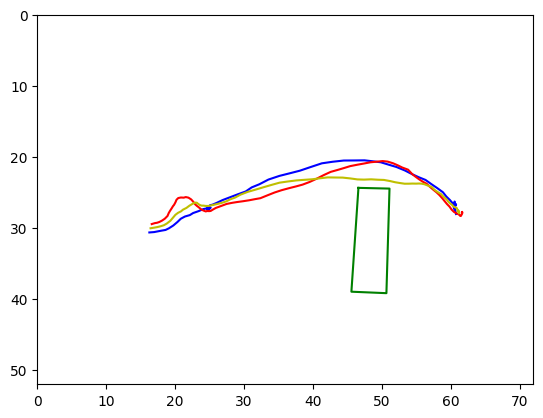

In [109]:
plt.plot(facing_frame.at[263,'interp_ts_nose_x_cm'],facing_frame.at[263,'interp_ts_nose_y_cm'],c ='b')
plt.plot(facing_frame.at[1158,'interp_ts_nose_x_cm'],facing_frame.at[1158,'interp_ts_nose_y_cm'],c = 'r')
plt.plot(facing_frame.at[263,'mean_interp_ts_nose_x_cm'],facing_frame.at[263,'mean_interp_ts_nose_y_cm'],c ='y')

plt.plot([facing_frame.at[263,'gt_obstacleTL_x_cm'], facing_frame.at[263,'gt_obstacleTR_x_cm'], facing_frame.at[263,'gt_obstacleBR_x_cm'], facing_frame.at[263,'gt_obstacleBL_x_cm'],facing_frame.at[263,'gt_obstacleTL_x_cm']],
            [facing_frame.at[263,'gt_obstacleTL_y_cm'], facing_frame.at[263,'gt_obstacleTR_y_cm'], facing_frame.at[263,'gt_obstacleBR_y_cm'], facing_frame.at[263,'gt_obstacleBL_y_cm'],facing_frame.at[263,'gt_obstacleTL_y_cm']],color='green')

plt.ylim([52,0]); plt.xlim([0, 72])

In [107]:
get_mean(facing_frame,facing_frame,'interp_ts_nose_x_cm')
get_mean(facing_frame,facing_frame,'interp_ts_nose_y_cm')


[16.43154193 17.00915103 17.40584265 17.88124476 18.35820306 18.79182209
 19.31380843 19.697384   20.0381465  20.42222628 20.84815791 21.14316367
 21.64011846 22.07896036 22.51588647 22.77980427 23.00251467 23.17787314
 23.23353548 23.36805016 23.52142875 23.65496236 23.86263874 24.12036793
 24.4203157  24.87204115 25.43366473 26.07966399 26.74930755 27.46253716
 28.02285441 28.69800948 29.49148739 30.5252342  31.69341172 32.78512581
 33.96311325 35.15768396 36.3501958  37.60668705 38.87003033 39.93594393
 41.05221535 42.15123651 43.26641255 44.32268446 45.44752056 46.4574718
 47.4232836  48.44574037 49.4224384  50.31096972 51.22389873 51.94832513
 52.64326995 53.32824388 53.92345245 54.44438455 54.96655947 55.41379438
 55.77747031 56.17392793 56.52528156 56.83580579 57.26049684 57.57863448
 57.80486698 58.06513947 58.37967365 58.57492805 58.76462527 59.05669753
 59.2662896  59.47532993 59.63691768 59.82656869 60.03556884 60.21770204
 60.3493191  60.52068189 60.71795376 60.88346138 60.

In [110]:
def get_mean(df_used,df_target,column):
    empty = np.zeros([len(df_used),1,100])
    count =  0
    for ind, row in df_used.iterrows():
        values = row[column]
        empty[count,0:] = row[column]
        count += 1
    mean_trace = np.nanmean(empty, axis=0)
    for ind in df_used.index.tolist():
        df_target.at[ind,'mean_' + column] = mean_trace[0,:].astype(object)

In [ ]:
empty = np.zeros([len(df),1,100])
count =  0
for ind, row in df_used.iterrows():
    values = row[column]
    empty[count,0:] = row[column]
    count += 1
median_trace = np.nanmean(empty, axis=0)
df_target.loc[df_used.index.tolist(),'mean_' + column] = median_trace[0,:].astype(object)

In [76]:
empty = np.zeros([len(df),100])
empty

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [116]:
J20RT

,first_poke,second_poke,trial_timestamps,trial_vidframes,nose_x,nose_y,nose_likelihood,leftear_x,leftear_y,leftear_likelihood,...,obstacle_intersect_nose_y,normalized_counts_intersect_nose_y,sum_normalized_counts_intersect_nose_y,bins_intersect_nose_y,mean_normalized_counts_intersect_nose_y,facing_angle,interp_ts_nose_x_cm,interp_ts_nose_y_cm,mean_interp_ts_nose_x_cm,mean_interp_ts_nose_y_cm
245,56396.382105,56401.703283,"[56396.387507, 56396.404108, 56396.420454, 563...","[264, 265, 266, 267, 268, 269, 270, 271, 272, ...","[112.0492172241211, 111.85668182373047, 111.71...","[263.0643615722656, 262.69403076171875, 262.92...","[0.9999997615814209, 0.9999996423721313, 0.999...","[123.26714324951172, 122.17658996582031, 122.3...","[273.4779052734375, 273.4393615722656, 273.583...","[0.9999998807907104, 0.9999997615814209, 0.999...",...,"[14.09143771475114, 17.580916801380493, 18.300...","[0, 0.047619047619047616, 0.9523809523809528, ...",1.0,"[-15.0, -12.0, -9.0, -6.0, -3.0, 0.0, 3.0, 6.0...","[0.0412907772511108, 0.1518709321352525, 0.276...",False,"[16.132638080191107, 16.511459108852236, 16.90...","[23.565557072912735, 23.344467484793448, 23.12...","[16.198296915737906, 16.627483229220413, 16.89...","[25.442294204335187, 25.197527180928667, 24.98..."
246,56401.703283,56405.103193,"[56401.705612, 56401.722419, 56401.73966, 5640...","[[583, 584, 585, 586, 587, 588, 589, 590, 591,...","[567.846923828125, 567.9541015625, 567.9830932...","[261.62213134765625, 261.7710266113281, 261.85...","[0.9999982118606567, 0.9999979734420776, 0.999...","[559.8572998046875, 560.25341796875, 560.58520...","[249.90591430664062, 250.23562622070312, 250.2...","[0.9999986886978149, 0.9999984502792358, 0.999...",...,"[36.575057946054, 35.061340301420366, 34.46040...","[0, 0, 0, 0, 0, 0, 0, 0.18181818181818182, 0.8...",1.0,"[-15.0, -12.0, -9.0, -6.0, -3.0, 0.0, 3.0, 6.0...","[0.0023809523809523807, 0.02353328781900211, 0...",True,"[55.901839087329726, 55.88402530534814, 55.799...","[28.325503048454205, 28.167545252336808, 28.08...","[55.7767343126436, 55.37882788511695, 54.99541...","[26.832723001629986, 26.72441531874639, 26.623..."
247,56405.103193,56415.839680,"[56405.106944, 56405.123494, 56405.141068, 564...","[787, 788, 789, 790, 791, 792, 793, 794, 795, ...","[112.341796875, 112.5261459350586, 112.2376403...","[262.132080078125, 261.9194030761719, 262.1935...","[0.9999998807907104, 0.9999998807907104, 0.999...","[124.35699462890625, 124.48033905029297, 124.6...","[271.0626525878906, 270.6658020019531, 271.431...","[0.9999998807907104, 0.9999998807907104, 0.999...",...,"[14.22569768356614, 15.37019164071948, 17.7050...","[0.02197802197802198, 0.06593406593406594, 0.3...",1.0,"[-15.0, -12.0, -9.0, -6.0, -3.0, 0.0, 3.0, 6.0...","[0.030321349536689718, 0.08265405522305395, 0....",False,"[16.309510183918775, 17.70456524275399, 18.262...","[24.919011320455443, 23.79554976537464, 23.033...","[16.200759956059944, 16.829995608243767, 17.26...","[25.012141875035635, 24.54230338232988, 24.191..."
248,56415.839680,56420.066956,"[56415.843865, 56415.861337, 56415.877235, 564...","[[1431, 1432, 1433, 1434, 1435, 1436, 1437, 14...","[569.6924438476562, 570.3181762695312, 570.292...","[260.84686279296875, 260.5827941894531, 260.42...","[0.9999996423721313, 0.9999996423721313, 0.999...","[554.6183471679688, 554.9428100585938, 555.338...","[254.00350952148438, 254.08241271972656, 254.0...","[0.9999994039535522, 0.9999994039535522, 0.999...",...,"[37.02545389936552, 37.04984808648651, 35.7554...","[0, 0, 0, 0, 0, 0, 0, 0, 0.9444444444444448, 0...",1.0,"[-15.0, -12.0, -9.0, -6.0, -3.0, 0.0, 3.0, 6.0...","[0.007798080472499077, 0.01977010392708067, 0....",True,"[55.88624153626936, 55.73837983709519, 55.5988...","[31.26828357776337, 31.596717398923804, 31.727...","[55.79792543353822, 55.330424297410964, 54.904...","[32.16786406879464, 32.02513266382128, 31.8707..."
249,56420.066956,56430.414502,"[56420.078784, 56420.095475, 56420.112051, 564...","[1685, 1686, 1687, 1

In [195]:
clrs = ['r','g','b','k']
keylist = ['area_TL','leftportT']
key = 'mean_{}_x_cm'.format(keylist)
'{}/{}'.format(date,ani)

'1.0'

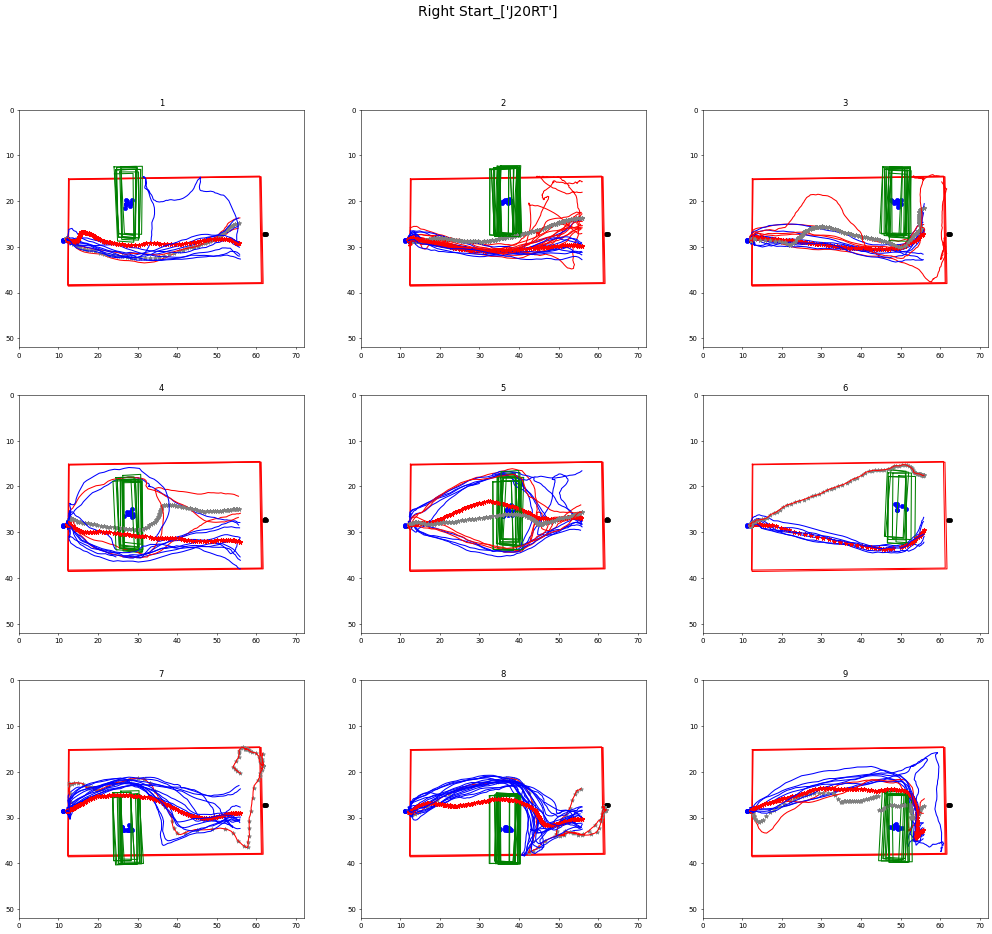

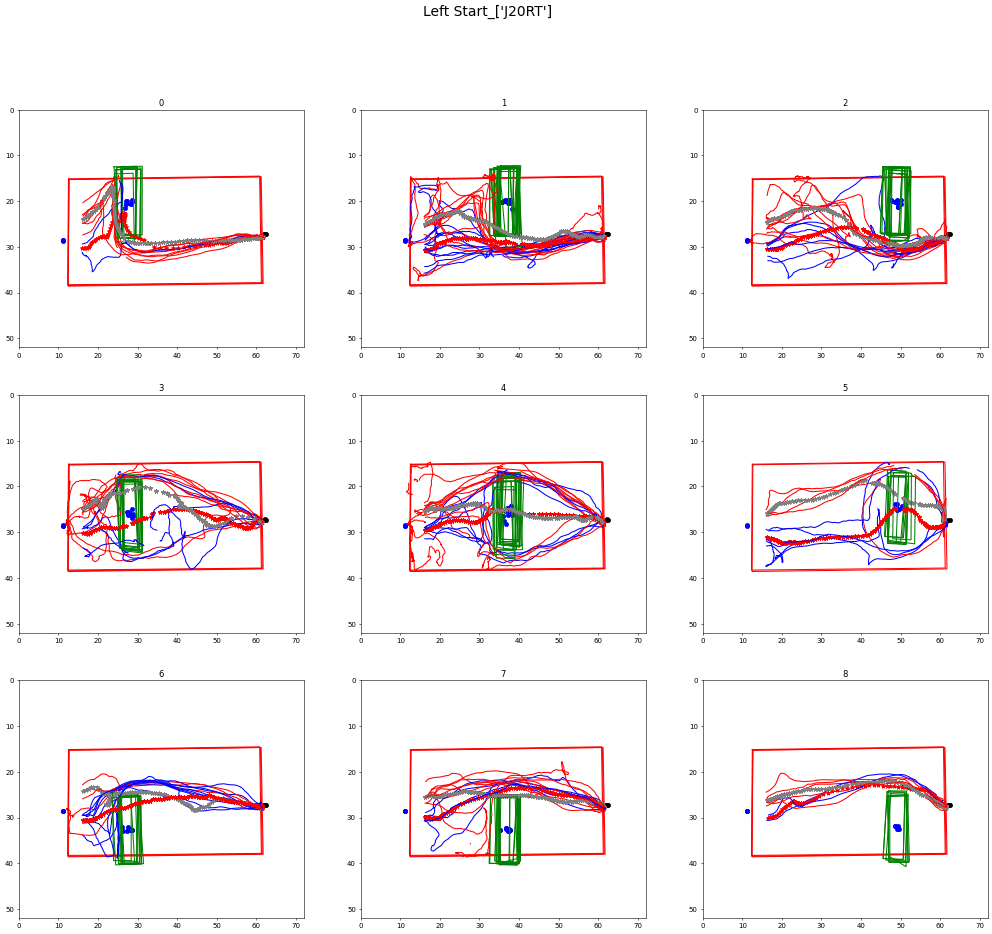

In [154]:
## plot raw traces and mean trace based on facing angle
by_direction = J20RT.groupby(['odd'])
for direction,direction_frame in by_direction:
    fig, ax = plt.subplots(3,3, figsize=(25,21),dpi=50)
    if direction == False:
        fig.suptitle('Right Start'+'_'+str(J20RT['animal'].unique()), size = 20) 
        right_by_cluster = direction_frame.groupby(['cluster_label'])
        for cluster,cluster_frame in right_by_cluster:
            plt.subplot(3,3,cluster+1)
            plt.gca().set_title(str(cluster+1))
            plt.plot([cluster_frame['mean_arenaTL_x_cm'].unique(), cluster_frame['mean_arenaTR_x_cm'].unique(), cluster_frame['mean_arenaBR_x_cm'].unique(), cluster_frame['mean_arenaBL_x_cm'].unique(),cluster_frame['mean_arenaTL_x_cm'].unique()],
                        [cluster_frame['mean_arenaTL_y_cm'].unique(), cluster_frame['mean_arenaTR_y_cm'].unique(), cluster_frame['mean_arenaBR_y_cm'].unique(), cluster_frame['mean_arenaBL_y_cm'].unique(),cluster_frame['mean_arenaTL_y_cm'].unique()],color='red')
            plt.scatter(cluster_frame['mean_leftportT_x_cm'].unique(),cluster_frame['mean_leftportT_y_cm'].unique(),color='blue')
            plt.scatter(cluster_frame['mean_rightportT_x_cm'].unique(),cluster_frame['mean_rightportT_y_cm'].unique(),color='black')
            for ind,row in cluster_frame.iterrows():
                plt.subplot(3,3,cluster+1)
                #plt.plot([row['arenaTL_x_cm'], row['arenaTR_x_cm'], row['arenaBR_x_cm'], row['arenaBL_x_cm'],row['arenaTL_x_cm']],
                        #[row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBR_y_cm'], row['arenaBL_y_cm'],row['arenaTL_y_cm']],color='red')
                plt.plot([row['gt_obstacleTL_x_cm'], row['gt_obstacleTR_x_cm'], row['gt_obstacleBR_x_cm'], row['gt_obstacleBL_x_cm'],row['gt_obstacleTL_x_cm']],
                        [row['gt_obstacleTL_y_cm'], row['gt_obstacleTR_y_cm'], row['gt_obstacleBR_y_cm'], row['gt_obstacleBL_y_cm'],row['gt_obstacleTL_y_cm']],color='green')
                plt.scatter(row['gt_obstacle_cen_x_cm'],row['gt_obstacle_cen_y_cm'],color='blue')
                #plt.scatter(row['leftportT_x_cm'],row['leftportT_y_cm'],color='blue')
                #plt.scatter(row['rightportT_x_cm'],row['rightportT_y_cm'],color='black')

                
                    #plt.scatter(row['wobstacle_x_cm'], row['wobstacle_y_cm'], c = list(mcolors.TABLEAU_COLORS)[ row['obstacle_cluster']])
                plt.ylim([52,0]); plt.xlim([0, 72])
                if row['facing_angle'] == True: 
                    plt.plot(row['mean_interp_ts_nose_x_cm'],row['mean_interp_ts_nose_y_cm'],'*',c = 'red')
                    plt.plot(row['ts_nose_x_cm'],row['ts_nose_y_cm'], c ='b') 
                if row['facing_angle'] == False:
                    plt.plot(row['mean_interp_ts_nose_x_cm'],row['mean_interp_ts_nose_y_cm'],'*',c = 'grey')
                    plt.plot(row['ts_nose_x_cm'],row['ts_nose_y_cm'],c = 'r') 
    if direction == True:
        fig.suptitle('Left Start'+'_'+str(J20RT['animal'].unique()), size = 20) 
        left_by_cluster = direction_frame.groupby(['cluster_label'])
        for cluster,cluster_frame in left_by_cluster:
            plt.subplot(3,3,cluster+1)
            plt.gca().set_title(str(cluster))
            plt.plot([cluster_frame['mean_arenaTL_x_cm'].unique(), cluster_frame['mean_arenaTR_x_cm'].unique(), cluster_frame['mean_arenaBR_x_cm'].unique(), cluster_frame['mean_arenaBL_x_cm'].unique(),cluster_frame['mean_arenaTL_x_cm'].unique()],
                        [cluster_frame['mean_arenaTL_y_cm'].unique(), cluster_frame['mean_arenaTR_y_cm'].unique(), cluster_frame['mean_arenaBR_y_cm'].unique(), cluster_frame['mean_arenaBL_y_cm'].unique(),cluster_frame['mean_arenaTL_y_cm'].unique()],color='red')
            plt.scatter(cluster_frame['mean_leftportT_x_cm'].unique(),cluster_frame['mean_leftportT_y_cm'].unique(),color='blue')
            plt.scatter(cluster_frame['mean_rightportT_x_cm'].unique(),cluster_frame['mean_rightportT_y_cm'].unique(),color='black')
            for ind,row in cluster_frame.iterrows():
                plt.subplot(3,3,cluster+1)
                #plt.plot([row['arenaTL_x_cm'], row['arenaTR_x_cm'], row['arenaBR_x_cm'], row['arenaBL_x_cm'],row['arenaTL_x_cm']],
                        #[row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBR_y_cm'], row['arenaBL_y_cm'],row['arenaTL_y_cm']],color='red')
                plt.plot([row['gt_obstacleTL_x_cm'], row['gt_obstacleTR_x_cm'], row['gt_obstacleBR_x_cm'], row['gt_obstacleBL_x_cm'],row['gt_obstacleTL_x_cm']],
                        [row['gt_obstacleTL_y_cm'], row['gt_obstacleTR_y_cm'], row['gt_obstacleBR_y_cm'], row['gt_obstacleBL_y_cm'],row['gt_obstacleTL_y_cm']],color='green')
                plt.scatter(row['gt_obstacle_cen_x_cm'],row['gt_obstacle_cen_y_cm'],color='blue')
                #plt.scatter(row['leftportT_x_cm'],row['leftportT_y_cm'],color='blue')
                #plt.scatter(row['rightportT_x_cm'],row['rightportT_y_cm'],color='black')
                #plt.plot(row['ts_nose_x_cm'],row['ts_nose_y_cm']) 
                
                    #plt.scatter(row['wobstacle_x_cm'], row['wobstacle_y_cm'], c = list(mcolors.TABLEAU_COLORS)[ row['obstacle_cluster']])
                plt.ylim([52,0]); plt.xlim([0, 72])
                if row['facing_angle'] == True: 
                    plt.plot(row['mean_interp_ts_nose_x_cm'],row['mean_interp_ts_nose_y_cm'],'*',c = 'red')
                    plt.plot(row['ts_nose_x_cm'],row['ts_nose_y_cm'], c ='b') 
                if row['facing_angle'] == False:
                    plt.plot(row['mean_interp_ts_nose_x_cm'],row['mean_interp_ts_nose_y_cm'],'*',c = 'grey')
                    plt.plot(row['ts_nose_x_cm'],row['ts_nose_y_cm'],c = 'r') 



    
                

 

In [190]:
df['ts_nose_x_cm'].iloc[]

0     [16.67372425465531, 17.34926158908538, 17.9952...
1     [55.74014379940179, 55.50069872458062, 55.4210...
10    [55.62237026334993, 54.98054616459371, 54.5215...
Name: ts_nose_x_cm, dtype: object

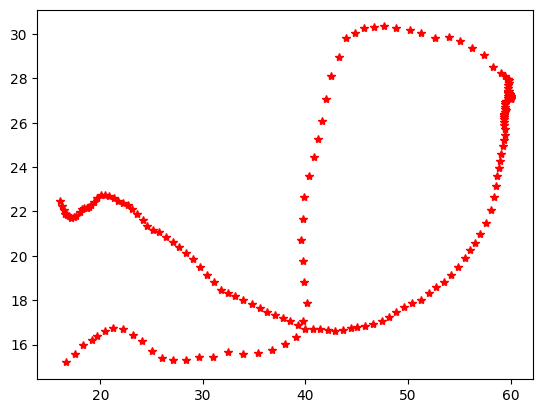

In [179]:
xinds = np.array([np.nanargmin(np.abs(df['ts_nose_x_cm'].iloc[n]-df['gt_obstacle_cen_x_cm'].iloc[n])) for n in range(len(df['ts_nose_x_cm']))])
yvals  = np.array([df['ts_nose_y_cm'].iloc[m][xinds[m]] for m in range(len(xinds))])
bottom = yvals<df['gt_obstacle_cen_y_cm'] #  True == right, False==Left
trial = 0
plt.plot(np.stack(df['interp_ts_nose_x_cm'][bottom])[trial],np.stack(df['interp_ts_nose_y_cm'][bottom])[trial],'*',c = 'red')
plt.plot(np.stack(df['interp_ts_nose_x_cm'][~bottom])[trial],np.stack(df['interp_ts_nose_y_cm'][~bottom])[trial],'*',c = 'red')
plt.show()

In [171]:
np.stack(df['interp_ts_nose_y_cm'][yvals<df['gt_obstacle_cen_y_cm']]

array([[22.471035207369436, 22.25184824215709, 22.060194240060163, ...,
        26.83361958032636, 26.911333759113504, 26.96242389029959],
       [31.66960196461883, 31.610430254873787, 31.70308575744932, ...,
        26.987294736834592, 27.02412209408067, 27.07587307958678],
       [32.983315431446194, 33.159379106419856, 33.26489208599445, ...,
        27.866748799281496, 27.834025736081557, 27.78638665386067],
       ...,
       [25.527922595359758, 25.470209506947764, 25.200131595300366, ...,
        27.719222814791436, 27.738899471369493, 27.731691511786533],
       [26.765485949766973, 26.846725119505752, 26.853287698435178, ...,
        27.586003517306818, 27.699074899902598, 27.771879733756748],
       [34.65284451128238, 34.84518724489917, 35.00198892315714, ...,
        28.70103688262847, 28.66213802446132, 28.597431460055386]],
      dtype=object)

In [ ]:
by_animal = df.groupby(['animal'])
for animal,animal_frame in by_animal:
    by_direction = animal_frame.groupby(['odd'])
    for direction,direction_frame in by_direction:
        fig, ax = plt.subplots(3,3, figsize=(25,21),dpi=50)
        if direction == False:
            fig.suptitle('Right Start'+'_'+str(animal_frame['animal'].unique()), size = 20)
            right_by_cluster = direction_frame.groupby(['cluster_label'])
            for cluster,cluster_frame in right_by_cluster:
                plt.subplot(3,3,cluster+1)
                plt.gca().set_title(str(cluster))
                plt.plot([cluster_frame['mean_arenaTL_x_cm'].unique(), cluster_frame['mean_arenaTR_x_cm'].unique(), cluster_frame['mean_arenaBR_x_cm'].unique(), cluster_frame['mean_arenaBL_x_cm'].unique(),cluster_frame['mean_arenaTL_x_cm'].unique()],
                            [cluster_frame['mean_arenaTL_y_cm'].unique(), cluster_frame['mean_arenaTR_y_cm'].unique(), cluster_frame['mean_arenaBR_y_cm'].unique(), cluster_frame['mean_arenaBL_y_cm'].unique(),cluster_frame['mean_arenaTL_y_cm'].unique()],color='red')
                plt.scatter(cluster_frame['mean_leftportT_x_cm'].unique(),cluster_frame['mean_leftportT_y_cm'].unique(),color='blue')
                plt.scatter(cluster_frame['mean_rightportT_x_cm'].unique(),cluster_frame['mean_rightportT_y_cm'].unique(),color='black')
                for ind,row in cluster_frame.iterrows():
                    plt.subplot(3,3,cluster+1)
                    #plt.plot([row['arenaTL_x_cm'], row['arenaTR_x_cm'], row['arenaBR_x_cm'], row['arenaBL_x_cm'],row['arenaTL_x_cm']],
                            #[row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBR_y_cm'], row['arenaBL_y_cm'],row['arenaTL_y_cm']],color='red')


                    plt.plot([row['gt_obstacleTL_x_cm'], row['gt_obstacleTR_x_cm'], row['gt_obstacleBR_x_cm'], row['gt_obstacleBL_x_cm'],row['gt_obstacleTL_x_cm']],
                            [row['gt_obstacleTL_y_cm'], row['gt_obstacleTR_y_cm'], row['gt_obstacleBR_y_cm'], row['gt_obstacleBL_y_cm'],row['gt_obstacleTL_y_cm']],color='green')




                    plt.scatter(row['gt_obstacle_cen_x_cm'],row['gt_obstacle_cen_y_cm'],color='blue')
                    #plt.scatter(row['leftportT_x_cm'],row['leftportT_y_cm'],color='blue')
                    #plt.scatter(row['rightportT_x_cm'],row['rightportT_y_cm'],color='black')
                    sns.scatterplot(x=row['ts_nose_x_cm'],y=row['ts_nose_y_cm'],hue = enumerate(row['ts_nose_x_cm']), palette ='magma',legend=False) 
                        #plt.scatter(row['wobstacle_x_cm'], row['wobstacle_y_cm'], c = list(mcolors.TABLEAU_COLORS)[ row['obstacle_cluster']])
                    plt.ylim([52,0]); plt.xlim([0, 72])
            pdf.savefig(); plt.close()
               

        if direction ==True:
            fig.suptitle('Left Start'+'_'+str(animal_frame['animal'].unique()), size = 20)
            left_by_cluster = direction_frame.groupby(['cluster_label'])
            for cluster,cluster_frame in left_by_cluster:
                plt.subplot(3,3,cluster+1)
                plt.gca().set_title(str(cluster))
                plt.plot([cluster_frame['mean_arenaTL_x_cm'].unique(), cluster_frame['mean_arenaTR_x_cm'].unique(), cluster_frame['mean_arenaBR_x_cm'].unique(), cluster_frame['mean_arenaBL_x_cm'].unique(),cluster_frame['mean_arenaTL_x_cm'].unique()],
                            [cluster_frame['mean_arenaTL_y_cm'].unique(), cluster_frame['mean_arenaTR_y_cm'].unique(), cluster_frame['mean_arenaBR_y_cm'].unique(), cluster_frame['mean_arenaBL_y_cm'].unique(),cluster_frame['mean_arenaTL_y_cm'].unique()],color='red')
                plt.scatter(cluster_frame['mean_leftportT_x_cm'].unique(),cluster_frame['mean_leftportT_y_cm'].unique(),color='blue')
                plt.scatter(cluster_frame['mean_rightportT_x_cm'].unique(),cluster_frame['mean_rightportT_y_cm'].unique(),color='black')
                for ind,row in cluster_frame.iterrows():
                    plt.subplot(3,3,cluster+1)
                    #plt.plot([row['arenaTL_x_cm'], row['arenaTR_x_cm'], row['arenaBR_x_cm'], row['arenaBL_x_cm'],row['arenaTL_x_cm']],
                            #[row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBR_y_cm'], row['arenaBL_y_cm'],row['arenaTL_y_cm']],color='red')


                    plt.plot([row['gt_obstacleTL_x_cm'], row['gt_obstacleTR_x_cm'], row['gt_obstacleBR_x_cm'], row['gt_obstacleBL_x_cm'],row['gt_obstacleTL_x_cm']],
                            [row['gt_obstacleTL_y_cm'], row['gt_obstacleTR_y_cm'], row['gt_obstacleBR_y_cm'], row['gt_obstacleBL_y_cm'],row['gt_obstacleTL_y_cm']],color='green')




                    plt.scatter(row['gt_obstacle_cen_x_cm'],row['gt_obstacle_cen_y_cm'],color='blue')
                    #plt.scatter(row['leftportT_x_cm'],row['leftportT_y_cm'],color='blue')
                   # plt.scatter(row['rightportT_x_cm'],row['rightportT_y_cm'],color='black')
                    sns.scatterplot(x=row['ts_nose_x_cm'],y=row['ts_nose_y_cm'],hue = enumerate(row['ts_nose_x_cm']), palette ='magma',legend=False) 
                        #plt.scatter(row['wobstacle_x_cm'], row['wobstacle_y_cm'], c = list(mcolors.TABLEAU_COLORS)[ row['obstacle_cluster']])
                    plt.ylim([52,0]); plt.xlim([0, 72])
           

In [ ]:
test = df.sample(1)
plt.plot(test['head_angle'].to_numpy()[0])

In [ ]:
#test = df.sample(1)
plt.gca().set_title(str(test['odd']))
for indx,i in enumerate(test['head_angle'].to_numpy()[0]):
    current_ang = i
    x1 = test['ts_nose_x_cm'].to_numpy()[0][indx]
    y1 = test['ts_nose_y_cm'].to_numpy()[0][indx]
    x2 = x1-3 * np.cos(current_ang)
    y2 = y1-3* np.sin(current_ang)
    plt.plot((x1,x2), (y1,y2), '-',color = 'black',alpha=0.3)
for indx,i in enumerate(test['body_angle'].to_numpy()[0]):
        current_ang = i
        x1 = test['ts_midspine_x_cm'].to_numpy()[0][indx]
        y1 = test['ts_midspine_y_cm'].to_numpy()[0][indx]
        x2 = x1-3 * np.cos(current_ang)
        y2 = y1-3* np.sin(current_ang)
        plt.plot((x1,x2), (y1,y2), '-',color = 'red',alpha=0.3)
plt.plot([test['arenaTL_x_cm'], test['arenaTR_x_cm'], test['arenaBR_x_cm'], test['arenaBL_x_cm'],test['arenaTL_x_cm']],
            [test['arenaTL_y_cm'], test['arenaTR_y_cm'], test['arenaBR_y_cm'], test['arenaBL_y_cm'],test['arenaTL_y_cm']],color='orange')
plt.plot([test['gt_obstacleTL_x_cm'], test['gt_obstacleTR_x_cm'], test['gt_obstacleBR_x_cm'], test['gt_obstacleBL_x_cm'],test['gt_obstacleTL_x_cm']],
        [test['gt_obstacleTL_y_cm'], test['gt_obstacleTR_y_cm'], test['gt_obstacleBR_y_cm'], test['gt_obstacleBL_y_cm'],test['gt_obstacleTL_y_cm']],color='green')
sns.scatterplot(x=test['obstacle_intersect_nose_x'].to_numpy()[0],y=test['obstacle_intersect_nose_y'].to_numpy()[0],hue = enumerate(test['obstacle_intersect_nose_x'].to_numpy()[0]), palette ='magma',legend=False)    
plt.scatter(test['gt_obstacleTL_x_cm'].to_numpy()[0],test['gt_obstacleTL_y_cm'].to_numpy()[0],color = 'blue')
plt.scatter(test['gt_obstacleTR_x_cm'].to_numpy()[0],test['gt_obstacleTR_y_cm'].to_numpy()[0],color = 'red')
plt.scatter(test['gt_obstacleBL_x_cm'].to_numpy()[0],test['gt_obstacleBL_y_cm'].to_numpy()[0],color = 'orange')
plt.scatter(test['gt_obstacleBR_x_cm'],test['gt_obstacleBR_y_cm'],color = 'green')
plt.scatter(test['gt_obstacle_cen_x_cm'].to_numpy()[0],test['gt_obstacle_cen_y_cm'].to_numpy()[0],color='blue')
plt.scatter(test['leftportT_x_cm'].to_numpy()[0],test['leftportT_y_cm'].to_numpy()[0],color='blue')
plt.scatter(test['rightportT_x_cm'].to_numpy()[0],test['rightportT_y_cm'].to_numpy()[0],color='black')
plt.scatter(test['ts_nose_x_cm'].to_numpy()[0],test['ts_nose_y_cm'].to_numpy()[0], color = 'c',s=1)
plt.scatter(test['ts_spine_x_cm'].to_numpy()[0],test['ts_spine_y_cm'].to_numpy()[0], color = 'm',s=1)
plt.ylim([52,0]); plt.xlim([0, 72])


In [ ]:
plt.plot(test['head_angle'].to_numpy()[0])

In [ ]:
plt.hist(test['head_angle'])

In [ ]:
df1

In [ ]:
#df1.loc[246,'obstacle_intersect_nose_y']-
plt.hist(((df1.loc[246,'obstacle_intersect_nose_y'] -  df1.loc[246,'obstacle_edge_mid_y_cm']))/len(df1.loc[246,'obstacle_intersect_nose_y']) )

In [ ]:
plt.plot([test['arenaTL_x_cm'], test['arenaTR_x_cm'], test['arenaBR_x_cm'], test['arenaBL_x_cm'],test['arenaTL_x_cm']],
                [test['arenaTL_y_cm'], test['arenaTR_y_cm'], test['arenaBR_y_cm'], test['arenaBL_y_cm'],test['arenaTL_y_cm']],color='orange')


plt.plot([test['gt_obstacleTL_x_cm'], test['gt_obstacleTR_x_cm'], test['gt_obstacleBR_x_cm'], test['gt_obstacleBL_x_cm'],test['gt_obstacleTL_x_cm']],
                [test['gt_obstacleTL_y_cm'], test['gt_obstacleTR_y_cm'], test['gt_obstacleBR_y_cm'], test['gt_obstacleBL_y_cm'],test['gt_obstacleTL_y_cm']],color='green')



for ind,i in enumerate(test['body_angle_tailbase']):

    current_ang = i
    x1 = test['ts_midspine_x_cm'][ind]
    y1 = test['ts_midspine_y_cm'][ind]
    x2 = x1+3 * np.cos(current_ang)
    y2 = y1+3* np.sin(current_ang)
    plt.plot((x1,x2), (y1,y2), '-',color = 'black',alpha=0.3)
    #plt.scatter(x1,y1,color = 'r',marker = '.')
    #plt.scatter(x2,y2,color = 'b',marker = '<')
    #sns.scatterplot(x=(x1,x2),y=(y1,y2),hue = enumerate(test['ts_nose_x_cm']),palette ='magma',legend=False)
for ind,i in enumerate(test['head_angle']):

    current_ang = i
    x1 = test['ts_nose_x_cm'][ind]
    y1 = test['ts_nose_y_cm'][ind]
    x2 = x1+3 * np.cos(current_ang)
    y2 = y1+3* np.sin(current_ang)
    plt.plot((x1,x2), (y1,y2), '-',color = 'red',alpha=0.3)
plt.plot([test['arenaTL_x_cm'], test['arenaTR_x_cm'], test['arenaBR_x_cm'], test['arenaBL_x_cm'],test['arenaTL_x_cm']],
                [test['arenaTL_y_cm'], test['arenaTR_y_cm'], test['arenaBR_y_cm'], test['arenaBL_y_cm'],test['arenaTL_y_cm']],color='orange')


plt.plot([test['gt_obstacleTL_x_cm'], test['gt_obstacleTR_x_cm'], test['gt_obstacleBR_x_cm'], test['gt_obstacleBL_x_cm'],test['gt_obstacleTL_x_cm']],
                [test['gt_obstacleTL_y_cm'], test['gt_obstacleTR_y_cm'], test['gt_obstacleBR_y_cm'], test['gt_obstacleBL_y_cm'],test['gt_obstacleTL_y_cm']],color='green')

#sns.scatterplot(x=test['obstacle_intersect_spine_x'],y=test['obstacle_intersect_spine_y'],hue = test['obstacle_intersect_spine_x'], palette ='magma',legend=False)    
plt.scatter(test['gt_obstacleTL_x_cm'],test['gt_obstacleTL_y_cm'],color = 'blue')
plt.scatter(test['gt_obstacleTR_x_cm'],test['gt_obstacleTR_y_cm'],color = 'red')
plt.scatter(test['gt_obstacleBL_x_cm'],test['gt_obstacleBL_y_cm'],color = 'orange')
plt.scatter(test['gt_obstacleBR_x_cm'],test['gt_obstacleBR_y_cm'],color = 'green')
plt.scatter(test['gt_obstacle_cen_x_cm'],test['gt_obstacle_cen_y_cm'],color='blue')
plt.scatter(test['leftportT_x_cm'],test['leftportT_y_cm'],color='blue')
plt.scatter(test['rightportT_x_cm'],test['rightportT_y_cm'],color='black')
plt.scatter(test['ts_spine_x_cm'],test['ts_spine_y_cm'], color = 'm',s=1)
#sns.scatterplot(x=test['ts_nose_x_cm'],y=test['ts_nose_y_cm'],hue = enumerate(test['ts_nose_x_cm']), palette ='magma',legend=False) 
plt.scatter(test['ts_nose_x_cm'][0],test['ts_nose_y_cm'][0],color='c')  
#plt.scatter(test['wobstacle_x_cm'], test['wobstacle_y_cm'], c = list(mcolors.TABLEAU_COLORS)[ test['obstacle_cluster']])
plt.ylim([52,0]); plt.xlim([0, 72])

In [ ]:
points_x = np.zeros(len(test['body_angle_tailbase']))
points_y = np.zeros(len(test['body_angle_tailbase']))
obstacle_top= (test['gt_obstacleTL_x_cm'],test['gt_obstacleTL_y_cm']-6)
obstacle_bottom=(test['gt_obstacleBL_x_cm'],test['gt_obstacleBL_y_cm']+6)
for indx,i in enumerate(test['body_angle_tailbase']):
    current_ang= i
    mouse_x1 = test['ts_midspine_x_cm'][indx]
    mouse_y1 = test['ts_midspine_y_cm'][indx]
    mouse_x2 = mouse_x1-200 * np.cos(current_ang)
    mouse_y2 = mouse_y1-200* np.sin(current_ang)
    intersect_point=intersect((mouse_x1,mouse_y1),(mouse_x2,mouse_y2),obstacle_top,obstacle_bottom)
    points_x[indx] = intersect_point[0]
    points_y[indx] = intersect_point[1]
points_x_all= np.nan_to_num(points_x)
points_y_all= np.nan_to_num(points_y)
points_x = points_x_all[points_x_all!=0]
points_y = points_y_all[points_y_all!=0]
test['all_obstacle_intersect_body_x'] = points_x_all.astype(object)
test['all_obstacle_intersect_body_y'] = points_y_all.astype(object)
test['obstacle_intersect_body_x'] = points_x.astype(object)
test['obstacle_intersect_body_y'] = points_y.astype(object)


In [ ]:
plt.hist(test['nose_y_cm'])
plt.xlim([52,0])

In [ ]:

len(test['all_obstacle_intersect_nose_y'])

In [ ]:
plt.plot([test['arenaTL_x_cm'], test['arenaTR_x_cm'], test['arenaBR_x_cm'], test['arenaBL_x_cm'],test['arenaTL_x_cm']],
                [test['arenaTL_y_cm'], test['arenaTR_y_cm'], test['arenaBR_y_cm'], test['arenaBL_y_cm'],test['arenaTL_y_cm']],color='orange')


plt.plot([test['gt_obstacleTL_x_cm'], test['gt_obstacleTR_x_cm'], test['gt_obstacleBR_x_cm'], test['gt_obstacleBL_x_cm'],test['gt_obstacleTL_x_cm']],
                [test['gt_obstacleTL_y_cm'], test['gt_obstacleTR_y_cm'], test['gt_obstacleBR_y_cm'], test['gt_obstacleBL_y_cm'],test['gt_obstacleTL_y_cm']],color='green')

plt.ylim([52,0]); plt.xlim([0, 72])
sns.scatterplot(x=test['obstacle_intersect_nose_x'],y=test['obstacle_intersect_nose_y'],hue = enumerate(test['obstacle_intersect_nose_x']), palette ='magma',legend=False)

In [ ]:
df.columns.to_numpy()

In [ ]:
plt.plot([test['arenaTL_x_cm'], test['arenaTR_x_cm'], test['arenaBR_x_cm'], test['arenaBL_x_cm'],test['arenaTL_x_cm']],
                [test['arenaTL_y_cm'], test['arenaTR_y_cm'], test['arenaBR_y_cm'], test['arenaBL_y_cm'],test['arenaTL_y_cm']],color='orange')


plt.plot([test['gt_obstacleTL_x_cm'], test['gt_obstacleTR_x_cm'], test['gt_obstacleBR_x_cm'], test['gt_obstacleBL_x_cm'],test['gt_obstacleTL_x_cm']],
                [test['gt_obstacleTL_y_cm'], test['gt_obstacleTR_y_cm'], test['gt_obstacleBR_y_cm'], test['gt_obstacleBL_y_cm'],test['gt_obstacleTL_y_cm']],color='green')


plt.scatter(test['ts_midspine_x_cm'][0],test['ts_midspine_y_cm'][0])
plt.ylim([52,0]); plt.xlim([0, 72])
print(test['odd'])
sns.scatterplot(x=test['ts_nose_x_cm'],y=test['ts_nose_y_cm'],hue = enumerate(test['ts_nose_x_cm']), palette ='magma',legend=False)


In [ ]:
print(np.mean((test['gt_obstacleTL_y_cm'],test['gt_obstacleTR_y_cm'])),np.mean((test['gt_obstacleBL_y_cm'],test['gt_obstacleBR_y_cm'])))

In [ ]:
noselist = test['ts_nose_x_cm']
odd_ind = np.argmax(nose_list>test['gt_obstacle_cen_x_cm'])

In [ ]:
noselist = test['ts_nose_x_cm']
odd_ind = np.argmax(noselist>test['gt_obstacle_cen_x_cm'])
print(test['gt_obstacle_cen_x_cm'],odd_ind)


In [ ]:
plt.hist(test['ts_nose_y_cm'][odd_ind:])
print(np.nanmean(test['ts_nose_y_cm'][odd_ind:]))

In [ ]:
plt.plot([test['arenaTL_x_cm'], test['arenaTR_x_cm'], test['arenaBR_x_cm'], test['arenaBL_x_cm'],test['arenaTL_x_cm']],
                [test['arenaTL_y_cm'], test['arenaTR_y_cm'], test['arenaBR_y_cm'], test['arenaBL_y_cm'],test['arenaTL_y_cm']],color='orange')


plt.plot([test['gt_obstacleTL_x_cm'], test['gt_obstacleTR_x_cm'], test['gt_obstacleBR_x_cm'], test['gt_obstacleBL_x_cm'],test['gt_obstacleTL_x_cm']],
                [test['gt_obstacleTL_y_cm'], test['gt_obstacleTR_y_cm'], test['gt_obstacleBR_y_cm'], test['gt_obstacleBL_y_cm'],test['gt_obstacleTL_y_cm']],color='green')
for ind,i in enumerate(test['head_angle']):

    current_ang = i
    x1 = test['ts_nose_x_cm'][ind]
    y1 = test['ts_nose_y_cm'][ind]
    x2 = x1+3 * np.cos(current_ang)
    y2 = y1+3* np.sin(current_ang)
    plt.plot((x1,x2), (y1,y2), '-',color = 'red',alpha=0.3)

plt.scatter(test['ts_midspine_x_cm'][0],test['ts_midspine_y_cm'][0])
plt.ylim([52,0]); plt.xlim([0, 72])
print(test['odd'])
sns.scatterplot(x=test['obstacle_intersect_body_x'],y=test['obstacle_intersect_body_y'],hue = enumerate(test['obstacle_intersect_body_x']), palette ='magma',legend=False)

In [ ]:
plt.plot(test['ts_nose_x_cm'],test['head_angle'])

In [ ]:
plt.plot([df.loc[45,'arenaTL_x_cm'], df.loc[45,'arenaTR_x_cm'], df.loc[45,'arenaBR_x_cm'], df.loc[45,'arenaBL_x_cm'],df.loc[45,'arenaTL_x_cm']],
                [df.loc[45,'arenaTL_y_cm'], df.loc[45,'arenaTR_y_cm'], df.loc[45,'arenaBR_y_cm'], df.loc[45,'arenaBL_y_cm'],df.loc[45,'arenaTL_y_cm']],color='orange')


plt.plot([df.loc[45,'gt_obstacleTL_x_cm'], df.loc[45,'gt_obstacleTR_x_cm'], df.loc[45,'gt_obstacleBR_x_cm'], df.loc[45,'gt_obstacleBL_x_cm'],df.loc[45,'gt_obstacleTL_x_cm']],
                [df.loc[45,'gt_obstacleTL_y_cm'], df.loc[45,'gt_obstacleTR_y_cm'], df.loc[45,'gt_obstacleBR_y_cm'], df.loc[45,'gt_obstacleBL_y_cm'],df.loc[45,'gt_obstacleTL_y_cm']],color='green')



for ind,i in enumerate(df.loc[45,'body_angle_tailbase']):

    current_ang = i
    x1 = df.loc[45,'ts_midspine_x_cm'][ind]
    y1 = df.loc[45,'ts_midspine_y_cm'][ind]
    x2 = x1+3 * np.cos(current_ang)
    y2 = y1+3* np.sin(current_ang)
    plt.plot((x1,x2), (y1,y2), '-',color = 'black',alpha=0.3)
    #plt.scatter(x1,y1,color = 'r',marker = '.')
    #plt.scatter(x2,y2,color = 'b',marker = '<')
    #sns.scatterplot(x=(x1,x2),y=(y1,y2),hue = enumerate(df.loc[45,'ts_nose_x_cm']),palette ='magma',legend=False)
for ind,i in enumerate(df.loc[45,'head_angle']):

    current_ang = i
    x1 = df.loc[45,'ts_nose_x_cm'][ind]
    y1 = df.loc[45,'ts_nose_y_cm'][ind]
    x2 = x1+3 * np.cos(current_ang)
    y2 = y1+3* np.sin(current_ang)
    #plt.plot((x1,x2), (y1,y2), '-',color = 'red',alpha=0.3)
plt.plot([df.loc[45,'arenaTL_x_cm'], df.loc[45,'arenaTR_x_cm'], df.loc[45,'arenaBR_x_cm'], df.loc[45,'arenaBL_x_cm'],df.loc[45,'arenaTL_x_cm']],
                [df.loc[45,'arenaTL_y_cm'], df.loc[45,'arenaTR_y_cm'], df.loc[45,'arenaBR_y_cm'], df.loc[45,'arenaBL_y_cm'],df.loc[45,'arenaTL_y_cm']],color='orange')


plt.plot([df.loc[45,'gt_obstacleTL_x_cm'], df.loc[45,'gt_obstacleTR_x_cm'], df.loc[45,'gt_obstacleBR_x_cm'], df.loc[45,'gt_obstacleBL_x_cm'],df.loc[45,'gt_obstacleTL_x_cm']],
                [df.loc[45,'gt_obstacleTL_y_cm'], df.loc[45,'gt_obstacleTR_y_cm'], df.loc[45,'gt_obstacleBR_y_cm'], df.loc[45,'gt_obstacleBL_y_cm'],df.loc[45,'gt_obstacleTL_y_cm']],color='green')

sns.scatterplot(x=df.loc[45,'obstacle_intersect_nose_x'],y=df.loc[45,'obstacle_intersect_nose_y'],hue = df.loc[45,'obstacle_intersect_nose_x'], palette ='magma',legend=False)    
plt.scatter(df.loc[45,'gt_obstacleTL_x_cm'],df.loc[45,'gt_obstacleTL_y_cm'],color = 'blue')
plt.scatter(df.loc[45,'gt_obstacleTR_x_cm'],df.loc[45,'gt_obstacleTR_y_cm'],color = 'red')
plt.scatter(df.loc[45,'gt_obstacleBL_x_cm'],df.loc[45,'gt_obstacleBL_y_cm'],color = 'orange')
plt.scatter(df.loc[45,'gt_obstacleBR_x_cm'],df.loc[45,'gt_obstacleBR_y_cm'],color = 'green')
plt.scatter(df.loc[45,'gt_obstacle_cen_x_cm'],df.loc[45,'gt_obstacle_cen_y_cm'],color='blue')
plt.scatter(df.loc[45,'leftportT_x_cm'],df.loc[45,'leftportT_y_cm'],color='blue')
plt.scatter(df.loc[45,'rightportT_x_cm'],df.loc[45,'rightportT_y_cm'],color='black')
plt.scatter(df.loc[45,'ts_spine_x_cm'],df.loc[45,'ts_spine_y_cm'], color = 'm',s=1)
#sns.scatterplot(x=df.loc[45,'ts_nose_x_cm'],y=df.loc[45,'ts_nose_y_cm'],hue = enumerate(df.loc[45,'ts_nose_x_cm']), palette ='magma',legend=False) 
plt.scatter(df.loc[45,'ts_nose_x_cm'][0],df.loc[45,'ts_nose_y_cm'][0],color='c')  
#plt.scatter(df.loc[45,'wobstacle_x_cm'], df.loc[45,'wobstacle_y_cm'], c = list(mcolors.TABLEAU_COLORS)[ df.loc[45,'obstacle_cluster']])
plt.ylim([52,0]); plt.xlim([0, 72])

In [ ]:
plt.stairs(x,bins1,fill=True)

In [ ]:
row_weights = np.ones_like(row['obstacle_intersect_nose_y'])/float(len(row['obstacle_intersect_nose_y']))
counts,bins=np.histogram((row['obstacle_intersect_nose_y'] -  row['obstacle_edge_mid_y_cm']),range=(-15,15),bins = 10 ,weights=row_weights)
print(counts,bins,row['obstacle_intersect_nose_y'] -  row['obstacle_edge_mid_y_cm'])

In [ ]:
by_animal = df.groupby(['animal'])
for animal,animal_frame in by_animal:
    for ind,row in animal_frame.iterrows():
        row_weights = np.ones_like(row['obstacle_intersect_nose_y'])/float(len(row['obstacle_intersect_nose_y']))
        counts,bins=np.histogram((row['obstacle_intersect_nose_y'] -  row['obstacle_edge_mid_y_cm']),range=(-15,15),bins = 10 ,weights=row_weights)
        df.at[ind,'normalized_counts_intersect_nose_y'] = counts.astype('object')
        df.at[ind,'sum_normalized_counts_intersect_nose_y'] = float(sum(counts))
        df.at[ind,'bins_intersect_nose_y'] = bins.astype('object')
        

        

In [ ]:
by_animal = df.groupby(['animal'])
for animal,animal_frame in by_animal:
    by_cluster =  animal_frame.groupby(['cluster_label'])
    for cluster,cluster_frame in by_cluster:
        by_direction = cluster_frame.groupby(['odd'])
        for direcetion,direction_frame in by_direction:
            mean_hist = np.mean(direction_frame['normalized_counts_intersect_nose_y'])
            for ind,row in direction_frame.iterrows():
                df.at[ind,'mean_normalized_counts_intersect_nose_y']=mean_hist.astype('object')
        

In [ ]:
by_animal = self.df.groupby(['animal'])
for animal,animal_frame in by_animal:
    by_cluster =  animal_frame.groupby(['cluster_label'])
    for cluster,cluster_frame in by_cluster:
        by_direction = cluster_frame.groupby(['odd'])
        for direcetion,direction_frame in by_direction:
            mean_hist = np.mean(direction_frame['normalized_counts_intersect_nose_y'])
            for ind,row in direction_frame.iterrows():
                self.df.at[ind,'mean_normalized_counts_intersect_nose_y']=mean_hist.astype('object')
        

In [ ]:
df.at[ind,'mean_normalized_counts_intersect_nose_y']

In [ ]:
p = np.mean(df['normalized_counts_intersect_nose_y'])

In [ ]:
plt.stairs(df.at[ind,'mean_normalized_counts_intersect_nose_y'].astype('float'),df.at[ind,'bins_intersect_nose_y'].astype('float'),fill=True)

In [ ]:
savepath,filename = 'D:obstacle_avoidance/figures/tracking_oa','101222_101322_101422_mean_nose_y_intersect_hist_121322'
pdf = PdfPages(os.path.join(savepath,(filename) + '_figs.pdf'))
by_animal = df.groupby(['animal'])
for animal,animal_frame in by_animal:
    by_direction = animal_frame.groupby(['odd'])
    for direction,direction_frame in by_direction:
        fig, ax = plt.subplots(3,3, figsize=(25,21),dpi=50)
        if direction == False:
            fig.suptitle('Right Start'+'_'+str(animal_frame['animal'].unique()), size = 20)
            right_by_cluster = direction_frame.groupby(['cluster_label'])
            for cluster,cluster_frame in right_by_cluster:
                plt.subplot(3,3,cluster+1)
                plt.gca().set_title(str(cluster))
                plt.stairs(cluster_frame.at[cluster_frame.index[0],'mean_normalized_counts_intersect_nose_y'].astype('float'),cluster_frame.at[cluster_frame.index[0],'bins_intersect_nose_y'].astype('float'),fill=True)
            pdf.savefig(); plt.close()
        if direction ==True:
            fig.suptitle('Left Start'+'_'+str(animal_frame['animal'].unique()), size = 20)
            left_by_cluster = direction_frame.groupby(['cluster_label'])
            for cluster,cluster_frame in left_by_cluster:
                plt.subplot(3,3,cluster+1)
                plt.gca().set_title(str(cluster))
                plt.stairs(cluster_frame.at[cluster_frame.index[0],'mean_normalized_counts_intersect_nose_y'].astype('float'),cluster_frame.at[cluster_frame.index[0],'bins_intersect_nose_y'].astype('float'),fill=True)
            pdf.savefig(); plt.close()
pdf.close()

                
                
                
                
                
               



In [ ]:
for ind, row in df.iterrows():
    spine_x = row['ts_midspine_x_cm']
    spine_y = row['ts_midspine_y_cm']
    midspine_x = row['ts_tailbase_x_cm']
    midspine_y = row['ts_tailbase_y_cm']
    angs = []
    for step in range(len(spine_x)):
        ang = np.arctan2(midspine_y[step] - spine_y[step],midspine_x[step] - spine_x[step])
        angs.append(ang)
    df.at[ind, 'body_angle_tailbase'] = np.array(angs).astype(object)


In [ ]:
df['body_angle_tailbase']

In [ ]:
df.at[1152,'tailbase_x_cm'][88:]

In [ ]:
keys = ['nose','leftear','rightear','spine','midspine','tailbase']
keys_list = list_columns(df,keys)
keys_list= [col for col in keys_list if 'likelihood' not in col]
keys_list= [col for col in keys_list if 'lind' not in col]
keys_list =[col for col in keys_list if 'intersect' not in col]
keys_list =[col for col in keys_list if 'ts' not in col]
keys_list =[col for col in keys_list if 'angle' not in col]
for ind, row in df.iterrows(): 
    if row['odd'] == True:
        nose_list = row['nose_x_cm'] 
        odd_ind = np.argmax(nose_list>16)
        for key in keys_list:
            df.at[ind,'ts_' + key] = row[key][odd_ind:]
                #use odd_ind to index into obstacle 
                # iterate over columns list  

                #create gt_obstacle points
    else: 
        nose_list = row['nose_x_cm']
        even_ind = np.argmax(nose_list<56)
        for key in keys_list:
            df.at[ind,'ts_' + key] = row[key][even_ind:]


In [ ]:
key

In [ ]:
row[key]


In [ ]:
np.argmax(row['nose_x_cm']>16)

In [ ]:
y_list = flatten_column(df,'head_angle')
plt.hist(y_list)

In [ ]:
plt.hist(test['head_angle'])